#**Tytuł:** Analiza rynku pracy Data Science w oparciu o popularne serwisy z ofertami


# Wstęp
Celem projektu jest zbudowanie modelu uczenia maszynowego na podstawie ofert pracy z popularnych portali, który będzie w stanie przewidzieć zarobki w oparciu o nasze doświadczenie i posiadane umiejętności. Narzędzie takie może w łatwy sposób wskazać zarobki jakich można oczekiwać na rozmowie o pracę, a przeprowadzona analiza eksploracyjna pozwoli “prześwietlić” rynek.

## Zakres pracy
* Pozyskanie danych przy pomocy metod web scraping’u, a dokładniej biblioteki BeautifulSoup w języku Python ze strony www.nofluffjobs.com. 
* Analiza, czyszczenie, imputacja, przygotowanie docelowego zbioru.
* Konieczne będzie kodowanie zmiennych kategorycznych oraz odpowiednie pogrupowanie elementów stacku technologicznego.
* Wizualizacja wyników.

## Ryzyka
* Trudność z pozyskaniem niektórych potrzebnych danych - szukanie alternatywnego źródła.
* Nieznana liczba możliwych do zamieszczenia w ogłoszeniu umiejętności, ich różnorodność i późniejsze grupowanie.
* Zablokowanie dostępu do strony spowodowane wysyłaniem bardzo dużej liczby requestów przy pobieraniu danych.
* Wiele stanowisk posiada bardzo podobne widełki zarobków, może to spowodować że otrzymywane wyniki będą za każdym razem bardzo podobne.

## Żródło danych
Na poniższym zrzucie ekranu ze strony www.nofluffjobs.com oznaczone są główne elementy, które poddane zostaną webscraping’owi.
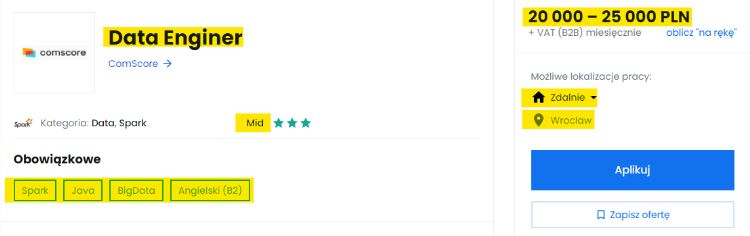

W ogłoszeniu zamieszczony jest również opis stanowiska, skrócona informacja o szczegółach oferty oraz przysługujące benefity. Pobranie tych danych może pozwolić dokonać ciekawej analizy rynku pracy.
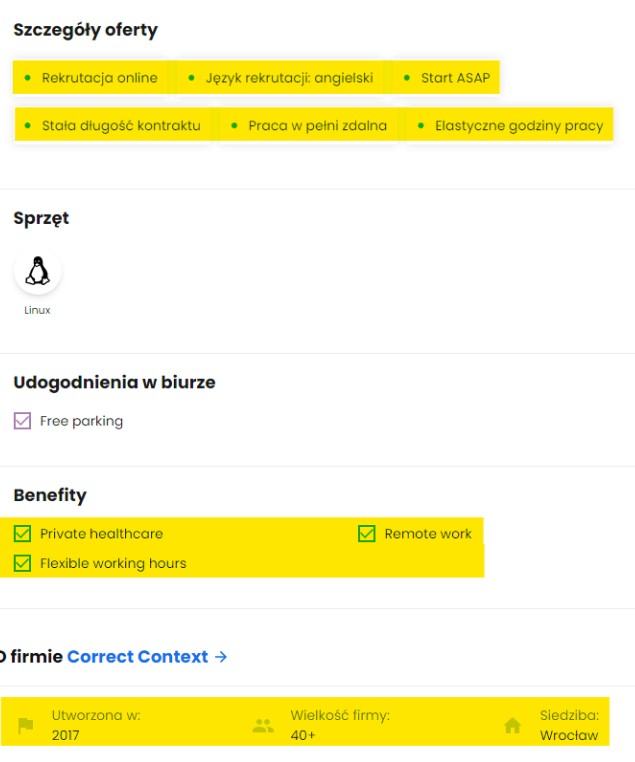

W celu pozyskania tych danych został przygotowany skrypt w Pythonie wykorzystujący bibliotekę BeautifulSoup, a jego działanie jest następujące:
* Na stronie głównej filtrujemy wyniki według interesujących nas kategorii: AI, Big Data, Business Intelligence.
* Ze wszystkich wyników pobierane są bezpośrednie odnośniki do ogłoszeń.
* Z każdego ogłoszenia pobierane są wskazane dane.

# Część właściwa pracy

## **Webscrape'ing**
Przygotowany został skrypt w języku Python umożliwiający zebranie danych ze strony www.nofluffjobs.com.  Wykorzystuje on biblioteki *Beautiful Soup* oraz *requests*. 

Beautiful Soup to biblioteka, która umożliwia parsowanie i przetwarzanie danych HTML oraz XML. Jest powszechnie wykorzystywana do ekstrakcji informacji ze stron internetowych.
W przygotowanym skrypcie wykorzystane zostały przede wszystkim metody takie jak find() i find_all() aby wyszukać i wydobyć interesujące nas elementy na podstawie tagów i atrybutów.

Requests natomiast służy do wykonywania zapytań HTTP. Umożliwia wykonywanie zapytań takich jak GET, POST, PUT, DELETE. Dzięki temu możliwe jest prowadzenie interakcji z serwerami, wysyłanie danych, pobieranie zawartości stron internetowych, pobieranie plików etc.

Instalacja brakujących pakietów i aktualizacja już istniejących.

In [ ]:
!pip install requests
!pip install beautifulsoup4
!pip install unidecode
!pip install sweetviz -qq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.9/235.9 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 78.3 MB/s eta 0:00:00


Import wszystkich potrzebnych bibliotek

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import textwrap
import re

from IPython.display import display
from bs4 import BeautifulSoup
from unidecode import unidecode

In [ ]:
# Ustalam bazowy adres URL zawierający kryteria wyszukiwania
base_url = 'https://nofluffjobs.com/pl/artificial-intelligence?criteria=category%3Dbig-data&page=1'

# Wysyłam żądanie GET, a odpowiedź przechowuję w zmiennej response
response = requests.get(base_url)

# Zawartość odpowiedzi przenoszę do zmiennej html
html = response.content

# Tworzę obiekt Beautiful Soup, i parsuję przekazany kod HTML
soup = BeautifulSoup(html, 'html.parser')

# Szukam wszystkich elementów 'a' o klasie 'page-link', są w nich numery kolejnych stron
page_numbers = []
for link in soup.find_all('a', class_='page-link'):
  number = link.text.strip()
  if not '»' in number: # elementy 'a' zawierały również przyciski ze strzałkami do przewijania stron, nie chcę ich przekazywać do listy page_numbers
    page_numbers.append(int(number))

# W liście filtered_links przechowywać będę odfiltrowane linki do poszczególnych ofert
filtered_links = []

for page in range(min(page_numbers), max(page_numbers)+1):
    # Tworzę adres URL do aktualnej strony z ogłoszeniami
    page_url = base_url.replace('page=1', f'page={page}')

    response = requests.get(page_url)    
    html = response.content
    soup = BeautifulSoup(html, 'html.parser')

    # Elementy 'a' zawierające 'href' pozwalają uzyskać fragmenty adresu poszczególnych adresów w postaci /pl/job/remote-backend-ai-engineer-golang-bash
    # na stronie były dodatkowo inne odnośniki ale interesujące nas możemy weryfikować po tym, że zawierają w sobie /job/
    links = []
    for a in soup.find_all('a', href=True):
        link = a['href']
        if '/job/' in link:
            links.append(link)

    # Do listy wyfiltrowanych linków dodaję kolejne łączac bazowy adres z uzyskanym wyżej odnośnikiem href
    filtered_links.extend(['https://nofluffjobs.com' + link for link in links])

Uzyskana lista linków prezentuje się w następujący sposób:

In [ ]:
filtered_links[:5]

['https://nofluffjobs.com/pl/job/senior-applied-research-scientist-infermedica-remote-1',
 'https://nofluffjobs.com/pl/job/regular-senior-data-scientist-hubquest-remote-2',
 'https://nofluffjobs.com/pl/job/remote-backend-ai-engineer-golang-bash',
 'https://nofluffjobs.com/pl/job/database-administrator-dentons-business-services-emea-remote',
 'https://nofluffjobs.com/pl/job/computer-vision-scientist-n-ix-remote-1']

Konfiguruję wyświetlanie DataFrame

In [ ]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:.2f}'.format

Poniższy kod jest tym właściwym Webscraping'iem:
* Dla każdego linku z odfiltrowanej listy generowane jest żądanie i pobierany kod HTML strony.
* Pobierane są następujące informacje:

  * Tytuł strony - Title
  * Nazwa stanowiska - Job Name
  * Nazwa firmy - Company Name
  * Szczegółowe dane o firmie - Company Details
  * Informacje o wymaganym doświadczeniu - Seniority Level
  * Widełki wynagrodzenia - Salary
  * Dwie informacji o lokalizacji pracy - Locations i Locations2
  * Wymagane umiejętności - Required Skills
  * Dodatkowe informacje o ogloszeniu - Details
  * Udogodnienia - Facilities
  * Benefity - Benefits
  * Wykorzystywany sprzęt - Hardware
  * Jak dawno temu została zamieszczona oferta - Offer Age

* Skrypt z każdym przejściem dopisuje informacje do listy ofert job_postings według ustalonego słownika job_dict
* Na końcu tworzona jest ramka danych df.

W trakcie analizy struktury danych na stronie metodą prób i błędów można było zauważyć niektóre zależności i wstępnie oczyścić dane, podzielić na podstawie słów kluczowych lub liczby spacji między kolejnymi wystąpieniami np. umiejętności.

In [ ]:
job_postings = []

for link in filtered_links:
  url = link

  response = requests.get(url)
  html = response.content
  soup = BeautifulSoup(html, 'html.parser')

  if soup.title is not None:
    title = soup.title.text

  if soup.find('h1', {'class':['font-weight-bold', 'font-weight-bold bigger']}) is not None:
    job_name = soup.find('h1', {'class':['font-weight-bold', 'font-weight-bold bigger']}).text

  if soup.find('a', {'id': 'postingCompanyUrl'}) is not None:
    company_name = soup.find('a', {'id': 'postingCompanyUrl'}).text
 
  company_details = []
  for li in soup.find_all('li'):
      detail = li.find('p')
      if detail is not None:
          text = detail.text.strip()
          company_details.append(text)

  if soup.find('span', {'class': 'mr-10 font-weight-medium ng-star-inserted'}) is not None:
    level = soup.find('span', {'class': 'mr-10 font-weight-medium ng-star-inserted'}).text.strip() 

  if soup.find('h4', {'class': 'tw-mb-0'}) is not None: 
    salary = soup.find('h4', {'class': 'tw-mb-0'}).text.strip() 

  locations = []
  for span in soup.find_all('div', class_='tw-flex tw-items-center tw-w-full ng-star-inserted'):
        location = span.text.strip()    
        locations.extend(location.split('  '))

  locations2 = []
  for span in soup.find_all(['a', 'span'], class_=['tw-py-1.5 tw-full tw-flex tw-cursor-pointer', 'tw-overflow-hidden tw-overflow-ellipsis tw-whitespace-nowrap']):
        location2 = span.text.strip()    
        locations2.extend(location2.split('  '))

  skills = []
  for span in soup.find_all('span', class_='no-cursor'):
      skill = span.text.strip()
      skills.append(skill)

  details = []
  for span in soup.find_all('li', class_='tw-inline-flex'):
      detail = span.text.strip()
      details.append(detail)

  facilities = []
  for span in soup.find_all('section', class_='purple', attrs={'commonpostingperks': True}):
      facility = span.text.strip().split('Udogodnienia w biurze\n ')[1]
      facilities.extend(facility.split('  '))     

  benefits = []
  for span in soup.find_all('section', class_='success', attrs={'commonpostingperks': True}):
      benefit = span.text.strip().split('Benefity\n ')[1]
      benefits.extend(benefit.split('  '))

  hardware = []
  for span in soup.find_all('span', class_='mobile-text tw-my-0 tw-mx-[-10px] tw-overflow-hidden tw-max-w-[80px] tw-mb-0 tw-block tw-text-[11px] tw-text-center'):
      hard = span.text.strip()
      hardware.extend(hard.split('  '))

  offer_age = soup.find('div', {'class': 'posting-time-row ng-star-inserted'}).text    
      
  job_dict = {'Title': title, 'Job Name': job_name,'Company Name': company_name, 'Company Details': company_details, 'Seniority Level': level, 'Required Skills': skills, 'Salary': salary, 'Locations': locations, 'Locations2': locations2, 'Details': details, 'Facilities': facilities, 'Benefits': benefits, 'Hardware': hardware, 'Offer Age': offer_age}

  job_postings.append(job_dict)

df = pd.DataFrame(job_postings)

df.head(5)

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,Facilities,Benefits,Hardware,Offer Age
0,Praca Senior Applied Research Scientist | AI | Infermedica Sp z.o.o | Zdalni...,Senior Applied Research Scientist,Infermedica Sp z.o.o,"[Utworzona w: 2012, Wielkość firmy: 200+, Siedziba: Wroclaw]",Senior,"[Python, Deep learning, AI, Machine Learning, Research and development, Rese...",20 000 – 25 000 PLN,[Zdalnie],"[Wrocław, Grabiszyńska 251, Zdalnie, Wrocław , Grabiszyńska 251]","[Rekrutacja online, Język rekrutacji: angielski, Start 2023-07-01, Stała dłu...","[Free coffee, Bike parking, Free beverages, No dress code, Startup atmosphere]","[Training budget, Private healthcare, Flat structure, Small teams, Employee ...","[Apple, Komputer: Notebook, Monitory: Jeden]",Oferta opublikowana dzisiaj
1,Praca Regular / Senior Data Scientist | AI | hubQuest | Zdalnie | No Fluff Jobs,Regular / Senior Data Scientist,hubQuest,[Oferta pracy ze wsparciem dla uchodźców],"Mid, Senior","[Python, Machine Learning, Data science, Statistics, scikit-learn, pandas, M...",20 000 – 28 500 PLN,[Zdalnie],"[Warsaw, Śniadeckich 10, Zdalnie, Warsaw , Śniadeckich 10]","[Rekrutacja online, Język rekrutacji: polski&angielski, Start ASAP, Stała dł...","[Free coffee, Bike parking, Shower, Free beverages, Modern office, No dress ...","[Sport subscription, Private healthcare, Training budget, International proj...","[Windows, Komputer: Notebook, as many as you need]",Oferta opublikowana dzisiaj
2,Praca Remote Backend/AI Engineer (Golang) | AI | Bash | Zdalnie | No Fluff Jobs,Remote Backend/AI Engineer (Golang),Bash,"[Utworzona w: 2023, Wielkość firmy: 1-9, Siedziba: San Francisco]",Mid,"[Golang, PostgreSQL, AWS, AWS EC2, AWS ECS, Route53, OpenAPI]",14 000 – 24 000 PLN,[Zdalnie],[],"[Rekrutacja online, Język rekrutacji: angielski, Start ASAP, Stała długość k...",[],"[Flat structure, Small teams, International projects]",[],Oferta opublikowana dzisiaj
3,Praca Database Administrator | Data | DENTONS BUSINESS SERVICES EMEA | Zdaln...,Database Administrator,DENTONS BUSINESS SERVICES EMEA,"[Utworzona w: 2013, Wielkość firmy: 300+, Siedziba: Warsaw]",Mid,"[SQL, Azure SQL, Microsoft SQL Server, Azure, Microsoft Azure, Performance t...",16 000 – 20 000 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lubelskie, Lubuskie, Ma...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lubelskie, Lubuskie, Małopolskie...","[Rekrutacja online, Język rekrutacji: angielski, Start ASAP, Stała długość k...","[Free coffee, Bike parking, Playroom, Shower, Mobile phone, Free parking, Mo...","[Flat structure, Small teams, International projects]","[Komputer: Notebook, Monitory: Opcjonalnie]",Oferta opublikowana dzisiaj
4,Praca Computer Vision Scientist | Data | N-iX | Zdalnie | No Fluff Jobs,Computer Vision Scientist,N-iX,"[Oferta pracy ze wsparciem dla uchodźców, Utworzona w: 2002, Wielkość firmy...",Senior,"[Java, Python, PyTorch, Machine Learning, AI, R]",29 081 – 43 622 PLN,[Zdalnie],"[Kraków, Zablocie 43 A, Zdalnie, Kraków , Zablocie 43 A]","[Rekrutacja online, Język rekrutacji: angielski, Start ASAP, Stała długość k...","[Free coffee, Modern office, Kitchen, Friendly atmosphere, No dress code]","[Flexible working hours and remote work possibility, paid vacations, Mentori...","[Apple, Komputer: Notebook, Monitory: Opcjonalnie]",Oferta opublikowana dzisiaj


Surowe dane w celu przyspieszenia prac i zachowania poprawności działania dalszej części kodu zostały umieszczone w pliku raw_dataframe.pkl który odpowiada ramce danych pakietu Pandas.

Dalsze opracowanie danych i analiza będzie bazować na danych pobranych 2023-06-08.

In [ ]:
#df.to_pickle('raw_dataframe.pkl')

## **Przygotowanie i transformacja danych**

Wczytanie surowych danych z dnia 2023-06-08.

In [ ]:
df = pd.read_pickle('raw_dataframe.pkl')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            157 non-null    object
 1   Job Name         157 non-null    object
 2   Company Name     157 non-null    object
 3   Company Details  157 non-null    object
 4   Seniority Level  157 non-null    object
 5   Required Skills  157 non-null    object
 6   Salary           157 non-null    object
 7   Locations        157 non-null    object
 8   Locations2       157 non-null    object
 9   Details          157 non-null    object
 10  Facilities       157 non-null    object
 11  Benefits         157 non-null    object
 12  Hardware         157 non-null    object
 13  Offer Age        157 non-null    object
dtypes: object(14)
memory usage: 17.3+ KB


Uzyskany zbiór surowych danych zawiera 157 ofert pracy z dziedziny Data Science. Na pierwszy rzut oka można pomyśleć że nie zawiera on żadnych wartości pustych gdyż w przypadku każdej z kolumn count z wartości non-null jest równy liczbie rekordów. 

Jest to niestety błędna informacja - podczas ekstrakcji danych ze strony tworzone były puste listy. W przypadku ramki danych mamy informację że w komórce znajduje się jakiś obiekt, mimo tego że jest on pusty. 

Ta informacja będzie konieczna do uwzględniania przy dalszej obróbce danych.

Zależność tę bardzo dobrze widać gdy wyświetlimy fragment ramki danych.

In [ ]:
df.head(5)

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,Facilities,Benefits,Hardware,Offer Age
0,Praca Business SQL Developer | Data | Harvey N...,Business SQL Developer,Harvey Nash Technology,"[Utworzona w: 1988, Wielkość firmy: 8000+, S...","Mid, Senior","[SQL, SQL Server, Python, Alteryx, Data wareho...",25 000 – 32 000 PLN,[],"[Hybrydowo, Warszawa]","[Rekrutacja online, Język rekrutacji: polski&a...","[Free coffee, Bike parking, Playroom, Free bev...","[Sport subscription, Training budget, Private ...",[],Oferta opublikowana dzisiaj
1,Praca Cloud Data Architect (GCP/Azure) | Data ...,Cloud Data Architect (GCP/Azure),Elitmind,"[Utworzona w: 2015, Wielkość firmy: +100, Lo...","Senior, Expert","[google cloud platform, ETL, SQL, Azure Cloud,...",24 000 – 32 000 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...","[Free coffee, Bike parking, Modern office, Off...","[Sport subscription, Training budget, Private ...","[Windows, Komputer: Notebook, Monitory: Dwa]",Oferta opublikowana dzisiaj
2,Praca Data Engineer | Data | ASTEK Polska | Z...,Data Engineer,ASTEK Polska,"[Utworzona w: 2007, Wielkość firmy: +1000, L...",Senior,"[Python, AWS, SQL]",21 000 – 27 300 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...",[],"[Sport subscription, Private healthcare, Inter...","[Linux, Windows, Komputer: Notebook, Monitory:...",Oferta opublikowana dzisiaj
3,Praca Mid/Senior MLOps Engineer | AI | GetInDa...,Mid/Senior MLOps Engineer,GetInData | Part of Xebia,"[Oferta pracy ze wsparciem dla uchodźców, Utwo...","Mid, Senior","[GCP, Java, Python, Kubernetes, Machine learni...",16 800 – 33 600 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski&a...","[Free coffee, Gym, Bike parking, Playroom, Fre...","[Sport subscription, Private healthcare, Flat ...","[Linux, Apple, Windows, Komputer: MacBook Pro,...",Oferta opublikowana dzisiaj
4,Praca Senior Machine Learning NLP LLM Engineer...,Senior Machine Learning NLP LLM Engineer,Kinetix Trading Solutions,"[Utworzona w: 2010, Wielkość firmy: 40+, Sie...","Senior, Expert","[Python, Machine learning, scikit-learn, NLP, ...",25 000 – 32 000 PLN,"[Zdalnie, Kujawsko-Pomorskie, Łódzkie, Lubelsk...","[Kujawsko-Pomorskie, Łódzkie, Lubelskie, Lubus...","[Rekrutacja online, Język rekrutacji: angielsk...",[],"[International projects, Small teams, Flat Org...","[Windows, Komputer: Virtual Environment]",Oferta opublikowana dzisiaj


### Mapowania

In [ ]:
# Funkcja pozwalająca utworzyć set unikalnych cech jeśli w komórce DF znajduje się lista
def get_unique_features(df, column):
    unique_features = set()
    for row in df[column]:
        unique_features.update(row)

    return unique_features

#### Stanowiska

Zmapowane stanowiska:
* Data Engineer
* Machine Learning Engineer
* Data Scientist
* Database Administrator
* Data Analyst
* AI Engineer
* Software Engineer
* Other

W tym przypadku proces mapowania odbywa się głównie po słowach kluczowych, jeśli nie znajdziemy odpowiedniego to przypisujemy wartość *Other*

In [ ]:
categories = {
    'Data Engineer': ['Data Engineers', 'Data Modeller','Data Labeling','Data Migration','SQL Developer','Data Engineer','ETL', 'Big Data Developer', 'Cloud Data Engineer', 'ETL Developer', 'Integration Specialist', 'Systems Engineer', 'Databricks','Senior/Expert Data Engineer', 'Data Engineer with BA skills', 'ETL Developer', 'Big Data Tech Lead', 'Integration Developer', 'Platform Engineer', 'Data Enginer', 'Data Architect'],
    'Machine Learning Engineer': ['Machine Learning Engineer', 'ML Engineer', 'NLP Engineer','MLOps Engineer', 'Senior Deep Learning Engineer', 'Senior Python Computer Vision Engineer', 'Spark', 'NLP', 'Machine Learning Operations', 'Deep learning', 'Reinforcement Learning', 'ML'],
    'Data Scientist': ['Data Scientist', 'Senior Applied Research Scientist', 'Scientist'],
    'Database Administrator': ['Database Administrator', 'DBA', 'Hurtowni Danych', 'Database Engineer', 'Managed Cloud Database Administrator', 'Database developer','Administrator'],
    'Data Analyst': ['Data Analyst', 'Junior Analyst','Junior Internal Auditor', 'Reporting Junior Developer', 'Tableau', 'Analityk','Data Quality Analyst', 'Analyst', '4HANA', 'Analityk'],
    'AI Engineer': ['AI Engineer', 'Artificial Intelligence Engineer', 'Head of AI', 'AI & Math (Open PhD Conduct)', 'Mid AI Engineer', 'Lead Python + Django AI', 'Backend/AI Engineer', 'Programista / Programistka AI', 'OpenAI API Integration Engineer', 'AI'],
    'Software Engineer': ['Software Engineer', 'Software Development Engineer', 'Financial Application Developer', 'C++ Developer', 'C# fejlesztő', 'Java', 'Python Developer', 'API Connect', 'Application Support Enginee', 'Support Engineer', 'C#', 'C++', 'JavaScript'],
    'Other': ['ESG initiative', 'Data Migration Consultant', 'Test Engineer', 'Application Support Engineer', 'Project Manager', 'SAP S/4HANA Consultant', 'PhD student', 'Test Automation Engineer', 'Adatmenedzsment-specialista és fejlesztő']
}

job_dictionary = {}

for job in df['Job Name']:
    for category, keywords in categories.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', job, re.IGNORECASE):
                job_dictionary[job] = category
                break
        if job in job_dictionary:
            break
    if job not in job_dictionary:
        job_dictionary[job] = 'Other'


In [ ]:
df['Job Name Mapped'] = df['Job Name'].map(job_dictionary)
display(df.head(2))

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,Facilities,Benefits,Hardware,Offer Age,Job Name Mapped
0,Praca Business SQL Developer | Data | Harvey N...,Business SQL Developer,Harvey Nash Technology,"[Utworzona w: 1988, Wielkość firmy: 8000+, S...","Mid, Senior","[SQL, SQL Server, Python, Alteryx, Data wareho...",25 000 – 32 000 PLN,[],"[Hybrydowo, Warszawa]","[Rekrutacja online, Język rekrutacji: polski&a...","[Free coffee, Bike parking, Playroom, Free bev...","[Sport subscription, Training budget, Private ...",[],Oferta opublikowana dzisiaj,Data Engineer
1,Praca Cloud Data Architect (GCP/Azure) | Data ...,Cloud Data Architect (GCP/Azure),Elitmind,"[Utworzona w: 2015, Wielkość firmy: +100, Lo...","Senior, Expert","[google cloud platform, ETL, SQL, Azure Cloud,...",24 000 – 32 000 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...","[Free coffee, Bike parking, Modern office, Off...","[Sport subscription, Training budget, Private ...","[Windows, Komputer: Notebook, Monitory: Dwa]",Oferta opublikowana dzisiaj,Data Engineer


#### Wymagane umiejętności

Umiejętności zostały przypisane do następujących kategorii:

* Business Intelligence, 
* Cloud, 
* Data Governance, 
* Data Integration, 
* Databases, 
* DevOps, 
* NoSQL, 
* Operating System, 
* Programming Language, 
* Python, 
* SQL, 
* Statistical Analysis, 
* Version Control, 
* Web Development, 
* Others

W przypadku umiejętności ze względu na ich liczbę i różnorodność lepszym podejściem okazało się zmapowanie każdego pojedynczego przypadku, był to proces bardzo pracochłonny i może nie obejmować wszystkich przyszłych wartości. Gdybyśmy chcieli wdrożyć taki system, konieczne byłoby przygotowanie rozszerzonego słownika i zabezpieczenia przed pojawieniem się niezmapowanych umiejętności.

In [ ]:
unique_skills = get_unique_features(df, 'Required Skills')
unique_skills

{'.NET',
 'A/B Testing',
 'ABAP',
 'AI',
 'AIX',
 'API',
 'API Connect',
 'API Design',
 'API testing',
 'APIS IQ-Software',
 'AWK',
 'AWS',
 'AWS Athena',
 'AWS CDK',
 'AWS Cloud',
 'AWS CloudFormation',
 'AWS EC2',
 'AWS ECS',
 'AWS Quicksight',
 'AWS S3',
 'AWS SageMaker',
 'Accounting',
 'Agile',
 'Airflow',
 'Akka',
 'Alteryx',
 'Amazon EMR',
 'Amazon Web Services',
 'Anaplan',
 'Angular',
 'Ansible',
 'Apache Airflow',
 'Apache Beam',
 'Apache Hadoop',
 'Apache Kafka',
 'Apache Spark',
 'Apex',
 'Applied Mathematics',
 'Artificial Intelligence',
 'Ataccama',
 'Athena',
 'Automation',
 'Avro',
 'Azure',
 'Azure Blob Storage',
 'Azure Cloud',
 'Azure Cosmos DB',
 'Azure Data',
 'Azure Data Factory',
 'Azure Data Lake',
 'Azure Data Warehouse',
 'Azure Databricks',
 'Azure DevOps',
 'Azure Event Hubs',
 'Azure ML',
 'Azure Pipelines',
 'Azure SQL',
 'Azure Synapse',
 'Azure Synapse Analytics',
 'BI',
 'BI tools',
 'BPMN',
 'BS',
 'BSc',
 'Bash',
 'Bayesian Networks',
 'Big Data',
 '

In [ ]:
mapped_skills = {
    '.NET': 'Others',
    'A/B Testing': 'Others',
    'ABAP': 'Others',
    'AI': 'Python',
    'AIX': 'Others',
    'API': 'Others',
    'API Connect': 'Others',
    'API Design': 'Others',
    'API testing': 'Others',
    'APIS IQ-Software': 'Others',
    'AWK': 'Others',
    'AWS': 'Cloud',
    'AWS Athena': 'SQL',
    'AWS CDK': 'Cloud',
    'AWS Cloud': 'Cloud',
    'AWS CloudFormation': 'Cloud',
    'AWS EC2': 'Cloud',
    'AWS ECS': 'Cloud',
    'AWS Quicksight': 'Cloud',
    'AWS S3': 'Cloud',
    'AWS SageMaker': 'Cloud',
    'Accounting': 'Others',
    'Agile': 'Others',
    'Airflow': 'Data Integration',
    'Akka': 'Others',
    'Alteryx': 'Others',
    'Amazon EMR': 'Others',
    'Amazon Web Services': 'Cloud',
    'Anaplan': 'Others',
    'Angular': 'Web Development',
    'Ansible': 'DevOps',
    'Apache Airflow': 'Data Integration',
    'Apache Beam': 'Data Integration',
    'Apache Hadoop': 'Databases',
    'Apache Kafka': 'Data Integration',
    'Apache Spark': 'Databases',
    'Apex': 'Others',
    'Applied Mathematics': 'Statistical Analysis',
    'Artificial Intelligence': 'Python',
    'Ataccama': 'Others',
    'Athena': 'SQL',
    'Automation': 'DevOps',
    'Avro': 'Others',
    'Azure': 'Cloud',
    'Azure Blob Storage': 'Cloud',
    'Azure Cloud': 'Cloud',
    'Azure Cosmos DB': 'NoSQL',
    'Azure Data': 'Cloud',
    'Azure Data Factory': 'Cloud',
    'Azure Data Lake': 'Cloud',
    'Azure Data Warehouse': 'Databases',
    'Azure Databricks': 'Cloud',
    'Azure DevOps': 'DevOps',
    'Azure Event Hubs': 'Cloud',
    'Azure ML': 'Cloud',
    'Azure Pipelines': 'DevOps',
    'Azure SQL': 'SQL',
    'Azure Synapse': 'Cloud',
    'Azure Synapse Analytics': 'Cloud',
    'BI': 'Business Intelligence',
    'BI tools': 'Business Intelligence',
    'BPMN': 'Others',
    'BS': 'Others',
    'BSc': 'Others',
    'Bash': 'DevOps',
    'Bayesian Networks': 'Others',
    'Big Data': 'Databases',
    'BigQuery': 'SQL',
    'Boomi': 'Data Integration',
    'Bootstrap': 'Web Development',
    'C': 'Programming Language',
    'C#': 'Programming Language',
    'C++': 'Programming Language',
    'CAN': 'Others',
    'CCH Tagetik': 'Others',
    'CD': 'DevOps',
    'CI': 'DevOps',
    'CI tools': 'DevOps',
    'CI/CD': 'DevOps',
    'CI/CD Pipelines': 'DevOps',
    'CRM': 'Others',
    'CSS': 'Web Development',
    'CUDA': 'Others',
    'Cassandra': 'Databases',
    'Cassandra/MongoDB': 'Databases',
    'Chartered Professional Accountant': 'Others',
    'CircleCI': 'DevOps',
    'ClickHouse': 'Databases',
    'Cloud': 'Cloud',
    'Cloud Migration Strategies': 'Cloud',
    'Cloud computing': 'Cloud',
    'Cloudera': 'Databases',
    'Cloudera (or any other) HADOOP distribution': 'Databases',
    'Collibra': 'Others',
    'Communication skills': 'Others',
    'Computer vision': 'Python',
    'Confluence': 'Others',
    'Cosmos DB': 'NoSQL',
    'Couchbase Server': 'NoSQL',
    'Critical thinking': 'Others',
    'DALEX': 'Others',
    'DB': 'Databases',
    'Data': 'Others',
    'Data Architecture': 'Data Governance',
    'Data Governance': 'Data Governance',
    'Data Integration': 'Data Integration',
    'Data Lake': 'Data Governance',
    'Data Platforms': 'Others',
    'Data Power': 'Data Governance',
    'Data Science': 'Python',
    'Data Vault': 'Data Governance',
    'Data analysis': 'Data Governance',
    'Data analytics': 'Data Governance',
    'Data engineering': 'Data Integration',
    'Data governance': 'Data Governance',
    'Data integration': 'Data Integration',
    'Data management': 'Data Governance',
    'Data mining': 'Data Governance',
    'Data modeling': 'Data Governance',
    'Data modelling': 'Data Governance',
    'Data pipelines': 'Data Integration',
    'Data science': 'Python',
    'Data visualization': 'Data Governance',
    'Data warehouse': 'Databases',
    'Data warehouses': 'Databases',
    'Databases': 'Databases',
    'Databases (relational/non-relational)': 'Databases',
    'Databricks': 'Others',
    'Deep learning': 'Python',
    'Degree': 'Others',
    'Dell': 'Others',
    'Design Patterns': 'Others',
    'Design thinking': 'Others',
    'DevOps': 'DevOps',
    'Django': 'Python',
    'Docker': 'DevOps',
    'Docker/Kubernetes': 'DevOps',
    'Doktorat z matematyki stosowanej': 'Others',
    'Dorobek Naukowy': 'Others',
    'Druid': 'Databases',
    'DynamoDB': 'NoSQL',
    'Dynatrace': 'Others',
    'E-commerce': 'Others',
    'EDI': 'Others',
    'ELK Stack': 'Others',
    'ELT': 'Data Integration',
    'EPM': 'Others',
    'ERP': 'Others',
    'ETL': 'Data Integration',
    'ETL tools': 'Data Integration',
    'ETL/ELT': 'Data Integration',
    'ElasticSearch': 'Others',
    'Elasticsearch': 'Others',
    'Embedded system': 'Others',
    'Engineering': 'Others',
    'English': 'Others',
    'Enterprise Architect': 'Others',
    'Ethernet': 'Others',
    'Excel': 'Others',
    'F#': 'Programming Language',
    'FastAPI': 'Python',
    'Firebase': 'Others',
    'Flask': 'Python',
    'Flink': 'Others',
    'FlinkSQL': 'Others',
    'Forecasting': 'Statistical Analysis',
    'GAN': 'Python',
    'GCP': 'Cloud',
    'GCP/AWS/Azure': 'Cloud',
    'GIS': 'Others',
    'Git': 'Version Control',
    'GitLab': 'Version Control',
    'GitHub': 'Version Control',
    'Go': 'Programming Language',
    'Google BigQuery': 'SQL',
    'Google Cloud': 'Cloud',
    'Google Cloud Platform': 'Cloud',
    'Google Cloud services': 'Cloud',
    'Google Kubernetes Engine': 'Cloud',
    'Google Suite': 'Others',
    'Gradle': 'Others',
    'Graph Databases': 'Databases',
    'GraphQL': 'Web Development',
    'Grid Computing': 'Others',
    'HDFS': 'Databases',
    'HQL': 'SQL',
    'Hadoop': 'Databases',
    'Hadoop Ecosystem': 'Databases',
    'Hardware': 'Others',
    'Hibernate': 'Others',
    'Highcharts': 'Web Development',
    'Hive': 'Databases',
    'HTML': 'Web Development',
    'HTML/CSS': 'Web Development',
    'HTTP': 'Web Development',
    'HTTP/REST': 'Web Development',
    'Hypothesis Testing': 'Statistical Analysis',
    'IaaS': 'Cloud',
    'IBM Cloud': 'Cloud',
    'IBM Cognos': 'Others',
    'IBM DB2': 'Databases',
    'IBM DataStage': 'Data Integration',
    'IBM InfoSphere': 'Others',
    'IBM Integration Bus': 'Data Integration',
    'IBM MDM': 'Others',
    'IBM Netezza': 'Databases',
    'IBM Power': 'Others',
    'IBM SPSS': 'Others',
    'IBM Spectrum': 'Others',
    'IBM WebSphere': 'Others',
    'IBM WebSphere Message Broker': 'Data Integration',
    'IIS': 'Web Development',
    'IMPALA': 'Databases',
    'ISO 26262': 'Others',
    'IT Security': 'Others',
    'ITIL': 'Others',
    'Identity Management': 'Others',
    'Image Processing': 'Python',
    'InfluxDB': 'Databases',
    'Information Retrieval': 'Others',
    'Informatica': 'Data Integration',
    'Informatica PowerCenter': 'Data Integration',
    'Infrastructure as Code': 'DevOps',
    'IoT': 'Others',
    'J2EE': 'Programming Language',
    'J2ME': 'Programming Language',
    'JBoss': 'Others',
    'JDBC': 'Programming Language',
    'Jenkins': 'DevOps',
    'Jest': 'Web Development',
    'JetBrains': 'Others',
    'Jira': 'Others',
    'Joomla': 'Web Development',
    'JSON': 'Others',
    'JSON Web Tokens': 'Web Development',
    'Jupyter Notebook': 'Python',
    'K8s': 'DevOps',
    'Kafka': 'Data Integration',
    'Kafka Streams': 'Data Integration',
    'Keras': 'Python',
    'Knime': 'Others',
    'Kotlin': 'Programming Language',
    'LDAP': 'Others',
    'LINQ': 'Programming Language',
    'LOVE': 'Others',
    'LSS': 'Others',
    'LabVIEW': 'Others',
    'Linux': 'Operating System',
    'Linux administration': 'Operating System',
    'Logstash': 'Others',
    'MS Office': 'Others',
    'MS SQL': 'SQL',
    'MS SQL Server': 'SQL',
    'MS Windows': 'Operating System',
    'MS Word': 'Others',
    'MSSQL': 'SQL',
    'MVP': 'Others',
    'Machine Learning': 'Python',
    'Machine Learning algorithms': 'Python',
    'Machine Learning models': 'Python',
    'MapReduce': 'Databases',
    'MariaDB': 'SQL',
    'Market Research': 'Others',
    'Matplotlib': 'Python',
    'Mathematics': 'Others',
    'Matrix': 'Others',
    'MediaWiki': 'Web Development',
    'Memcached': 'Others',
    'Mentoring': 'Others',
    'Meteor.js': 'Web Development',
    'Microservices': 'Others',
    'Microsoft Azure': 'Cloud',
    'Microsoft Dynamics': 'Others',
    'Microsoft Excel': 'Others',
    'Microsoft Office': 'Others',
    'Microsoft Power BI': 'Business Intelligence',
    'Microsoft SQL Server': 'SQL',
    'Microsoft Windows': 'Operating System',
    'MongoDB': 'NoSQL',
    'Mongoose': 'NoSQL',
    'Monitoring': 'DevOps',
    'MySQL': 'SQL',
    'NLP': 'Python',
    'NO SQL': 'NoSQL',
    'NOSQL': 'NoSQL',
    'Natural Language Processing': 'Python',
    'Network': 'Others',
    'Network security': 'Others',
    'Neural Networks': 'Python',
    'Nifi': 'Data Integration',
    'Node.js': 'Web Development',
    'NumPy': 'Python',
    'Object Oriented Programming': 'Programming Language',
    'Objective-C': 'Programming Language',
    'OpenCV': 'Python',
    'Operating System': 'Operating System',
    'Oracle': 'Databases',
    'Oracle BI': 'Business Intelligence',
    'Oracle DB': 'Databases',
    'Oracle Database': 'Databases',
    'Oracle EBS': 'Others',
    'Oracle ERP': 'Others',
    'Oracle Financials': 'Others',
    'Oracle Forms': 'Others',
    'Oracle PL/SQL': 'SQL',
    'Oracle SQL': 'SQL',
    'Oracle SOA': 'Others',
    'PL/SQL': 'SQL',
    'PLC': 'Others',
    'POSIX': 'Operating System',
    'Pandas': 'Python',
    'Pentaho': 'Data Integration',
    'Perl': 'Programming Language',
    'Photoshop': 'Others',
    'Php': 'Web Development',
    'Pig': 'Databases',
    'Pivotal Cloud Foundry': 'Cloud',
    'Pivotal Tracker': 'Others',
    'PostgreSQL': 'SQL',
    'Power BI': 'Business Intelligence',
    'PowerShell': 'DevOps',
    'Presto': 'SQL',
    'Process Optimization': 'Others',
    'Process design': 'Others',
    'Product Management': 'Others',
    'Programming Language': 'Programming Language',
    'Progress': 'Others',
    'Prolog': 'Programming Language',
    'Project Management': 'Others',
    'PySpark': 'Python',
    'Puppet': 'DevOps',
    'Pyramid': 'Python',
    'Pytorch': 'Python',
    'Qlik Sense': 'Business Intelligence',
    'QlikView': 'Business Intelligence',
    'Quantitative Analysis': 'Statistical Analysis',
    'R': 'Programming Language',
    'RapidMiner': 'Others',
    'React': 'Web Development',
    'React Native': 'Web Development',
    'Red Hat': 'Operating System',
    'Red Hat OpenShift': 'DevOps',
    'Regression Analysis': 'Statistical Analysis',
    'Relational Databases': 'Databases',
    'Reporting': 'Business Intelligence',
    'REST': 'Web Development',
    'REST API': 'Web Development',
    'RESTful': 'Web Development',
    'RESTful API': 'Web Development',
    'RethinkDB': 'NoSQL',
    'Robot Framework': 'Others',
    'Ruby': 'Programming Language',
    'Ruby on Rails': 'Web Development',
    'Rust': 'Programming Language',
    'SAS': 'Others',
    'SASS': 'Web Development',
    'SDET': 'Others',
    'SE': 'Others',
    'SEO': 'Others',
    'SOLID': 'Others',
    'SPSS': 'Others',
    'SQL': 'SQL',
    'SQL Server': 'SQL',
    'SQL Server Integration Services (SSIS)': 'Data Integration',
    'SQL Server Reporting Services (SSRS)': 'Business Intelligence',
    'SQLite': 'SQL',
    'SSH': 'Others',
    'Scala': 'Programming Language',
    'Scikit-Learn': 'Python',
    'Scipy': 'Python',
    'Scripting': 'Programming Language',
    'Search Engine Optimization': 'Others',
    'Security': 'Others',
    'ServiceNow': 'Others',
    'Shell Scripting': 'DevOps',
    'Siemens': 'Others',
    'Signal Processing': 'Python',
    'Software Development': 'Programming Language',
    'Software Engineering': 'Programming Language',
    'Software Testing': 'Programming Language',
    'Solidity': 'Others',
    'Spark': 'Databases',
    'Spark Streaming': 'Data Integration',
    'Splunk': 'Others',
    'Spring': 'Programming Language',
    'Spring Boot': 'Programming Language',
    'Spring Framework': 'Programming Language',
    'Spring MVC': 'Programming Language',
    'Spring Security': 'Programming Language',
    'Statistics': 'Statistical Analysis',
    'Storm': 'Data Integration',
    'Struts': 'Programming Language',
    'Supervised Learning': 'Python',
    'Swift': 'Programming Language',
    'Symfony': 'Web Development',
    'T-SQL': 'SQL',
    'TDD': 'Others',
    'TFS': 'DevOps',
    'Talend': 'Data Integration',
    'TeamCity': 'DevOps',
    'TensorFlow': 'Python',
    'Teradata': 'Databases',
    'Time Management': 'Others',
    'Time Series Analysis': 'Statistical Analysis',
    'Torch': 'Python',
    'Tosca': 'Others',
    'TypeScript': 'Programming Language',
    'UI Design': 'Web Development',
    'UI/UX': 'Web Development',
    'UI/UX Design': 'Web Development',
    'UX Design': 'Web Development',
    'Ubuntu': 'Operating System',
    'Unsupervised Learning': 'Python',
    'User Experience Design': 'Web Development',
    'User Interface Design': 'Web Development',
    'VBA': 'Programming Language',
    'VMware': 'Others',
    'Vagrant': 'DevOps',
    'Version Control': 'Version Control',
    'VirtualBox': 'Others',
    'Virtualization': 'Others',
    'Vue.js': 'Web Development',
    'WCF': 'Programming Language',
    'WPF': 'Programming Language',
    'Web API': 'Web Development',
    'Web Development': 'Web Development',
    'Web Scraping': 'Web Development',
    'Webpack': 'Web Development',
    'Wireshark': 'Others',
    'Wordpress': 'Web Development',
    'Writing': 'Others',
    'Xamarin': 'Programming Language',
    'XML': 'Others',
    'XSLT': 'Web Development',
    'Yii': 'Web Development',
    'Zend Framework': 'Web Development',
    'Zookeeper': 'Data Integration',
    'ZooKeeper': 'Data Integration',
    'pandas': 'Python',
    'scikit-learn': 'Python',
    'PyTorch': 'Python',
    'XGBoost': 'Python',
    'finance information systems development and management': 'Others',
    'TSQL': 'SQL',
    'PowerBI': 'Data Governance',
    'Big data': 'Databases',
    'SciPy': 'Python',
    'Relational database': 'Databases',
    'Windows': 'Operating System',
    'IBM': 'Operating System',
    'Machine learning': 'Python',
    'Snowflake':'Cloud',
    'google cloud platform':'Cloud',
    'Google cloud platform':'Cloud',
    'Machine Vision': 'Python',
    'Machine Vision'
    'Natural language processing': 'Python',
    'Tableau': 'Data Governance',
    'RedHat': 'Operating System',
    'Unix': 'Operating System',
    'TCP': 'Others',
    'Network protocols': 'Others',
    'Glue': 'Others',
    'Golang': 'Programming Language',
    'Google Analytics': 'Others',
    'Google Data Studio': 'Data Integration',
    'Google Sheets (formulars)': 'Others',
    'Google Workspace': 'Others',
    'Google cloud': 'Cloud',
    'Grafana': 'Others',
    'Groovy': 'Others',
    'HANA': 'Others',
    'Haskell': 'Others',
    'Helm': 'Others',
    'High availability': 'Others',
    'Hyperion/Essbase': 'Others',
    'IAM': 'Others',
    'IaC': 'Others',
    'IaaC': 'Others',
    'Inmon': 'Others',
    'Integration': 'Data Integration',
    'Istio': 'Others',
    'JENKINS': 'Others',
    'JIRA': 'Others',
    'JMS': 'Others',
    'JPA': 'Others',
    'Java': 'Programming Language',
    'Java Script': 'Web Development',
    'Java or Scala or Python': 'Programming Language',
    'JavaScript': 'Web Development',
    'Kafka Streaming/Kafka Connect': 'Others',
    'Kanban': 'Others',
    'Key Vault': 'Others',
    'Kimball': 'Others',
    'Kinesis': 'Others',
    'Knowledge-based systems': 'Others',
    'Kubernetes': 'Databases',
    'Langchain': 'Others',
    'LightGBM': 'Others',
    'Looker': 'Others',
    'MATLAB': 'Others',
    'MLOps': 'Others',
    'MLflow': 'Others',
    'MONGO': 'NoSQL',
    'MS Excel': 'Others',
    'MS Project': 'Others',
    'MSc': 'Others',
    'MapR Stack': 'Others',
    'Matplot': 'Python',
    'Maven': 'Others',
    'Message queue': 'Others',
    'Metaflow': 'Others',
    'Natural language processing': 'Python',
    'NetSuite': 'Others',
    'Network Security': 'Others',
    'Network Time Protocol': 'Others',
    'Network configuration': 'Others',
    'Network function virtualization': 'Others',
    'Network protocols': 'Operating System',
    'Network-attached storage': 'Others',
    'Networking': 'Operating System',
    'Networks': 'Operating System',
    'Nginx': 'Others',
    'NiFi': 'Others',
    'Nomad': 'Others',
    'OOP': 'Others',
    'OneStream': 'Others',
    'Oozie': 'Others',
    'Open API': 'Others',
    'OpenAPI': 'Others',
    'Operating system': 'Operating System',
    'Oracle Apex': 'Others',
    'Oracle Data Integrator': 'Data Integration',
    'PM': 'Others',
    'PMP': 'Others',
    'PUB': 'Others',
    'PaaS': 'Others',
    'People Management': 'Others',
    'Performance tuning': 'Others',
    'PhD': 'Others',
    'Prince2': 'Others',
    'Proactivity': 'Others',
    'Problem solving': 'Others',
    'Prototyping': 'Others',
    'Qlik': 'Others',
    'RDBM': 'Others',
    'RDBMS': 'Others',
    'RESTful APIs': 'Others',
    'RabbitMQ': 'Others',
    'React native': 'Programming Language',
    'Redis': 'NoSQL',
    'Redshift': 'Operating System',
    'Research': 'Others',
    'Research and development': 'Others',
    'Route53': 'Others',
    'S4 HANA': 'Others',
    'SAP': 'Others',
    'SD': 'Others',
    'SDK': 'Others',
    'SDLC': 'Others',
    'SHAP': 'Others',
    'SLAM': 'Others',
    'SOA': 'Others',
    'SOAP': 'Others',
    'SPARQL': 'Programming Language',
    'SQL Server Integration Services': 'Data Integration',
    'SQL Server Reporting Services': 'Data Integration',
    'SQL/NoSQL': 'Databases',
    'SaaS': 'Others',
    'Scikit-learn':'Python',
    'Seldon Core': 'Others',
    'Selenium': 'Python',
    'Shell': 'Operating System',
    'Software Development Life Cycle': 'Others',
    'Solar': 'Others',
    'Stakeholder Management': 'Others',
    'Statistical Testing': 'Statistical Analysis',
    'Statistical methods': 'Statistical Analysis',
    'Storage': 'Databases',
    'Structured Streaming': 'Others',
    'Sumo Logic': 'Others',
    'TIA': 'Others',
    'TM1': 'Others',
    'Team player': 'Others',
    'Tech Leadership': 'Others',
    'Telco': 'Others',
    'Terraform': 'Others',
    'Test automation': 'Others',
    'Test-driven development': 'Others',
    'TestCase Lab': 'Others',
    'Theano': 'Others',
    'Timescale': 'Others',
    'Timestream': 'Others',
    'Tworzenie Architektury AI "from the scratch"': 'Others',
    'UI': 'Others',
    'UML': 'Others',
    'UNIX/Linux': 'Operating System',
    'UX': 'Others',
    'User interface': 'Others',
    'VB': 'Others',
    'Vault': 'Others',
    'Version control system': 'Version Control',
    'Visio': 'Others',
    'Web applications': 'Web Development',
    'Web service': 'Web Development',
    'Web services': 'Web Development',
    'WebAssembly': 'Web Development',
    'XAI': 'Others',
    'XSD': 'Others',
    'YARN': 'Cloud',
    'Yarn': 'Cloud',
    'analytical skills': 'Others',
    'c++': 'Programming Language',
    'data modeling': 'Data Integration',
    'database':'Databases',
    'dbt': 'Others',
    'dimensional modeling': 'Others',
    'docker': 'Others',
    'git': 'Version Control',
    'iPaaS': 'Others',
    'informatica': 'Cloud',
    'linux': 'Operating System',
    'pytest': 'Python',
    'shell-bash': 'Operating System',
    'spaCy': 'Python',
    'working with scripts': 'Programming Language',
    'Łatwość w automatyzacji': 'Others',
    'BigData': 'Databases'
    }


In [ ]:
df['Required Skills Mapped'] = df['Required Skills'].apply(lambda skills: [mapped_skills.get(skill, skill) for skill in skills]) #zmapowanie umiejętności na podstawie słownika
df['Required Skills Mapped'] = df['Required Skills Mapped'].apply(lambda skills: list(set(skills))) #usunięcie zduplikowanych wartości w listach
display(df.head(2))

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,Facilities,Benefits,Hardware,Offer Age,Job Name Mapped,Required Skills Mapped
0,Praca Business SQL Developer | Data | Harvey N...,Business SQL Developer,Harvey Nash Technology,"[Utworzona w: 1988, Wielkość firmy: 8000+, S...","Mid, Senior","[SQL, SQL Server, Python, Alteryx, Data wareho...",25 000 – 32 000 PLN,[],"[Hybrydowo, Warszawa]","[Rekrutacja online, Język rekrutacji: polski&a...","[Free coffee, Bike parking, Playroom, Free bev...","[Sport subscription, Training budget, Private ...",[],Oferta opublikowana dzisiaj,Data Engineer,"[Others, Databases, SQL, Data Governance, Python]"
1,Praca Cloud Data Architect (GCP/Azure) | Data ...,Cloud Data Architect (GCP/Azure),Elitmind,"[Utworzona w: 2015, Wielkość firmy: +100, Lo...","Senior, Expert","[google cloud platform, ETL, SQL, Azure Cloud,...",24 000 – 32 000 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...","[Free coffee, Bike parking, Modern office, Off...","[Sport subscription, Training budget, Private ...","[Windows, Komputer: Notebook, Monitory: Dwa]",Oferta opublikowana dzisiaj,Data Engineer,"[Data Integration, Others, SQL, Cloud, Data Go..."


Weryfikacja czy unikalne zmapowane umiejętności są takim samym zbiorem jak te ze słownika *mapped_skills*.

In [ ]:
unique_skills_after = get_unique_features(df, 'Required Skills Mapped')
textwrap.wrap(str(sorted(unique_skills_after)), width=300)

["['Business Intelligence', 'Cloud', 'Data Governance', 'Data Integration', 'Databases', 'DevOps', 'NoSQL', 'Operating System', 'Others', 'Programming Language', 'Python', 'SQL', 'Statistical Analysis', 'Version Control', 'Web Development']"]

In [ ]:
textwrap.wrap(str(sorted(list(set(mapped_skills.values())))), width=300)

["['Business Intelligence', 'Cloud', 'Data Governance', 'Data Integration', 'Databases', 'DevOps', 'NoSQL', 'Operating System', 'Others', 'Programming Language', 'Python', 'SQL', 'Statistical Analysis', 'Version Control', 'Web Development']"]

Po mapowaniu mamy taki sam zestaw cech w obu zbiorach.

#### Wymagany staż

In [ ]:
df['Seniority Level'] = df['Seniority Level'].str.replace(' ', '')
df['Seniority Level'].unique()

array(['Mid,Senior', 'Senior,Expert', 'Senior', 'Mid', 'Expert', 'Junior',
       'Trainee,Junior'], dtype=object)

In [ ]:
df['Seniority Level'] = df['Seniority Level'].str.replace('Trainee,Junior', 'Junior')
df['Seniority Level'].unique()

array(['Mid,Senior', 'Senior,Expert', 'Senior', 'Mid', 'Expert', 'Junior'],
      dtype=object)

In [ ]:
seniority_mapping = {
    'Junior': 1,
    'Mid': 2,
    'Mid,Senior': 3,
    'Senior': 4,
    'Senior,Expert': 5,
    'Expert': 6
}

df['Seniority Level Num'] = df['Seniority Level'].map(seniority_mapping)
display(df.head(2))

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,Facilities,Benefits,Hardware,Offer Age,Job Name Mapped,Required Skills Mapped,Seniority Level Num
0,Praca Business SQL Developer | Data | Harvey N...,Business SQL Developer,Harvey Nash Technology,"[Utworzona w: 1988, Wielkość firmy: 8000+, S...","Mid,Senior","[SQL, SQL Server, Python, Alteryx, Data wareho...",25 000 – 32 000 PLN,[],"[Hybrydowo, Warszawa]","[Rekrutacja online, Język rekrutacji: polski&a...","[Free coffee, Bike parking, Playroom, Free bev...","[Sport subscription, Training budget, Private ...",[],Oferta opublikowana dzisiaj,Data Engineer,"[Others, Databases, SQL, Data Governance, Python]",3
1,Praca Cloud Data Architect (GCP/Azure) | Data ...,Cloud Data Architect (GCP/Azure),Elitmind,"[Utworzona w: 2015, Wielkość firmy: +100, Lo...","Senior,Expert","[google cloud platform, ETL, SQL, Azure Cloud,...",24 000 – 32 000 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...","[Free coffee, Bike parking, Modern office, Off...","[Sport subscription, Training budget, Private ...","[Windows, Komputer: Notebook, Monitory: Dwa]",Oferta opublikowana dzisiaj,Data Engineer,"[Data Integration, Others, SQL, Cloud, Data Go...",5


#### Udogodnienia

W mojej ocenie kolumna *Facilities* nie wymaga dodatkowego mapowania, jest ich zdecydowanie mniej.

In [ ]:
unique_facilities = get_unique_features(df, 'Facilities')
textwrap.wrap(str(unique_facilities), width=300)

["{'Office in the city center', 'Startup atmosphere', 'Free coffee', 'Team lunch', 'In-house trainings', 'Mobile phone', 'No dress code', 'Playroom', 'Chillout space', 'Free parking', 'Play room', 'Massage chairs', 'Friendly atmosphere', 'language classess', 'Modern office', 'Xbox', 'Normal atmosphere",
 ":)', 'Knowledge sharing', 'Foosball table', 'Bike parking', 'Free snacks', 'Group insurance', 'Garden', 'Sport package', 'Shower', 'Massages', 'Yoga and mindfulness exercises', 'Canteen', 'Free tea and coffee', 'Free beverages', 'Free fresh fruits', 'Kitchen', 'Free lunch', 'Gym', 'In-house hack",
 "days', 'Przyjazna atmosfera pracy', 'Free breakfast', 'e-learning platforms'}"]

#### Benefity

Opisane grupy benefitów:
* Allowance, 
* Assistance, 
* Benefits, 
* Bonus, 
* Certifications, 
* Childcare, 
* Compensation, 
* Compensations, 
* Crypto, 
* Employment, 
* Equipment, 
* Events, 
* Fitness, 
* Health, 
* Insurance, 
* International, 
* Investment, 
* Knowledge Sharing, 
* Language, 
* Learning & Development, 
* Leave,
* Legal, 
* Office, 
* Organization, 
* Paid Holidays,
* Paid Time Off, 
* Payment, 
* Pension, 
* Pet-friendly,
* Profit Sharing, 
* Programs, 
* Recognition, 
* Resources, 
* Sick Leave, 
* Sustainability, 
* Team, 
* Technology, 
* Training & Conferences, 
* Volunteering, 
* Wellness, 
* Work Environment, 
* Work-life Balance

In [ ]:
unique_benefits = get_unique_features(df, 'Benefits')
textwrap.wrap(str(unique_benefits), width=300)

["{'Multisport', 'Dental care', 'Copyright tax', 'In-house trainings', 'Life & group insurance', 'Home office', 'Insurance', 'Squash', 'Private health care', 'Cafeteria', 'life insurance', 'Conference & Training budget', 'Life & Travel Insurance', 'VIP Medical Care Package', 'Stock options',",
 "'Zakładowy Fundusz Świadczeń Socjalnych', 'Only employees are entitled to benefits package', 'International team', 'Remote work', 'Group life insurance', 'Mentoring', 'Payment every 2 weeks', 'Polish Lessons', 'Dog friendly office', 'Life insurance', 'Annual bonus depending on performance', 'Newest",
 "technologies', 'Knowledge sharing', 'Access to e-learning platform', 'Educational and team building events', 'volunteer opportunities', 'Integration budget', 'Scope to enhance existing skills', 'Training budget', 'Co-financed sport card with unlimited usage', 'Integration and lunch budget', 'Benefit",
 "platform', 'Monthly budget for integration', 'Certificates', 'Flat structure', '2 additional d

In [ ]:
benefit_mappings = {
    'benefit': 'Benefits',
    '2 additional days for volunteering events': 'Volunteering',
    '26 days of paid holidays for everyone': 'Paid Holidays',
    '33 days of sick-leave with 100% of salary paid': 'Sick Leave',
    '360° Feedback & Mentoring programme': 'Learning & Development',
    'Access to e-learning platform': 'Learning & Development',
    'Active tech community': 'Knowledge Sharing',
    'Amazon library': 'Resources',
    'Annual bonus': 'Bonus',
    'Annual bonus depending on performance': 'Bonus',
    'Annual performance based bonus': 'Bonus',
    'Any equipment you need': 'Equipment',
    'Ask Henry': 'Knowledge Sharing',
    'Benefit platform': 'Benefits',
    'Bonus for recommendation': 'Bonus',
    'Buddy Program': 'Learning & Development',
    'Build strong career graph': 'Learning & Development',
    'Cafeteria': 'Benefits',
    'Cafeteria system': 'Benefits',
    'Career development': 'Learning & Development',
    'Career growth': 'Learning & Development',
    'Certificates': 'Certifications',
    'Childcare support programme': 'Childcare',
    'Cloud Certifications': 'Certifications',
    'Co-financed sport card with unlimited usage': 'Fitness',
    'Co-working budget': 'Office',
    'Company share purchase plan': 'Investment',
    'Compensations of certifications': 'Compensations',
    'Competitive compensation': 'Compensation',
    'Conference & Training budget': 'Training & Conferences',
    'Conference budget': 'Training & Conferences',
    'Conferences': 'Training & Conferences',
    'Copy rights': 'Legal',
    'Copyright tax': 'Legal',
    'Crypto starter kit': 'Crypto',
    'Dental & Mental health': 'Health',
    'Dental care': 'Health',
    'Development within working hours (8 days/year)': 'Learning & Development',
    'Dog friendly office': 'Pet-friendly',
    'Educational and team building events': 'Learning & Development',
    'Educational assistance reimbursement': 'Learning & Development',
    'Educational events': 'Learning & Development',
    'Employee Stock Ownership Plan': 'Investment',
    'Employee assistance program': 'Assistance',
    'Employee programs': 'Programs',
    'Employee referral bonus': 'Bonus',
    'Employee stock purchase plan': 'Investment',
    'Employment contract or B2B': 'Employment',
    'Enel-Med health care plan': 'Health',
    'English lessons': 'Language',
    'English lessons with Native Speaker': 'Language',
    'Eye Care': 'Health',
    'Flat Orgnisation Structure': 'Organization',
    'Flat structure': 'Organization',
    'Flexible form of employment': 'Employment',
    'Flexible working hours': 'Work-life Balance',
    'Flexible working hours and remote work possibility': 'Work-life Balance',
    'Free consultations with a doctor in our office': 'Health',
    'Friendly atmosphere': 'Work Environment',
    'Group life insurance': 'Insurance',
    'Holiday allowance': 'Paid Holidays',
    'Holiday money': 'Paid Holidays',
    'Home Office Setup': 'Work Environment',
    'Home office': 'Work Environment',
    'In-house hack days': 'Events',
    'In-house trainings': 'Learning & Development',
    'Insurance': 'Insurance',
    'Integration and lunch budget': 'Events',
    'Integration budget': 'Events',
    'Integration events': 'Events',
    'Internal trainings/meetups': 'Learning & Development',
    'International clients': 'International',
    'International environment': 'International',
    'International projects': 'International',
    'International team': 'International',
    'Knowledge sharing': 'Knowledge Sharing',
    'Language classes': 'Language',
    'Language courses': 'Language',
    'Language courses reimbursement scheme': 'Language',
    'Life & Travel Insurance': 'Insurance',
    'Life & group insurance': 'Insurance',
    'Life and travel insurance': 'Insurance',
    'Life insurance': 'Insurance',
    'Long-term cooperation': 'Employment',
    'Lunch card': 'Benefits',
    'Luxmed': 'Health',
    'MacBook': 'Equipment',
    'Maintenance allowance': 'Allowance',
    'Masterclazz training': 'Training & Conferences',
    'Meals Subsidy in Office': 'Benefits',
    'Mental Health Support': 'Health',
    'Mental health care': 'Health',
    'Mental health support': 'Health',
    'Mentoring': 'Learning & Development',
    'Mentoring program': 'Learning & Development',
    'Modern technologies': 'Technology',
    'Monthly budget for integration': 'Events',
    'Monthly remote work subsidy': 'Work-life Balance',
    'MultiKafeteria': 'Benefits',
    'Multisport': 'Fitness',
    'Multisport card': 'Fitness',
    'MyBenefit': 'Benefits',
    'MyBenefit Cafeteria (benefits platform)': 'Benefits',
    'MyBenefit System': 'Benefits',
    'MyBenefit cafeteria': 'Benefits',
    'Newest technologies': 'Technology',
    'OK system': 'Benefits',
    'On-line foreign languages lessons': 'Language',
    'On-line training and certifications': 'Learning & Development',
    'Online courses': 'Learning & Development',
    'Only employees are entitled to benefits package': 'Benefits',
    'PPK option': 'Investment',
    'PTO': 'Paid Time Off',
    'Paid Parental Leave': 'Leave',
    'Paid leave': 'Leave',
    'Paid vacation': 'Paid Holidays',
    'Parental Leave': 'Leave',
    'Payment every 2 weeks': 'Payment',
    'Payment in USD': 'Payment',
    'Pension plan': 'Pension',
    'Pension scheme': 'Pension',
    'Pension scheme (PPE 4%)': 'Pension',
    'Pluralsight': 'Learning & Development',
    'Polish Lessons': 'Language',
    'Private health care': 'Health',
    'Private healthcare': 'Health',
    'Private insurance': 'Insurance',
    'Profit sharing': 'Profit Sharing',
    'Psychological support': 'Health',
    'Psychologist support': 'Health',
    'Referral bonus': 'Bonus',
    'Referral program': 'Bonus',
    'Remote work': 'Work-life Balance',
    'Salaries in different currencies': 'Payment',
    'Scope to enhance existing skills': 'Learning & Development',
    'Sick days': 'Leave',
    'Small teams': 'Work Environment',
    'Sport Subscription': 'Fitness',
    'Sport subscription': 'Fitness',
    'Squash': 'Fitness',
    'Stock options': 'Investment',
    'Team Events': 'Events',
    'Team building events': 'Events',
    'Team events': 'Events',
    'Team of experts': 'Team',
    'Technical communities': 'Knowledge Sharing',
    'Training budget': 'Training & Conferences',
    'Trainings': 'Training & Conferences',
    'Travel insurance': 'Insurance',
    'Udemy for business': 'Learning & Development',
    'Unlimited free days': 'Work-life Balance',
    'VIP Medical Care Package': 'Health',
    'Volunteer opportunities': 'Volunteering',
    'Wellness Days': 'Wellness',
    'Work on latest technologies': 'Technology',
    'Workation': 'Work-life Balance',
    'Working in a highly experienced team': 'Team',
    'Workstation reimbursement': 'Allowance',
    'Zakładowy Fundusz Świadczeń Socjalnych': 'Benefits',
    'life insurance': 'Insurance',
    'medical insurance': 'Insurance',
    'paid vacations': 'Paid Holidays',
    'professional development tools': 'Learning & Development',
    'renewable energy': 'Sustainability',
    'subsidized English classes': 'Language',
    'top performers awards': 'Recognition',
    'trainings, & conferences': 'Training & Conferences',
    'volunteer opportunities': 'Volunteering',
    'Leave': 'Leave'
}

In [ ]:
df['Benefits Mapped'] = df['Benefits'].apply(lambda benefits: [benefit_mappings.get(benefit, 'Other') for benefit in benefits])
df['Benefits Mapped'] = df['Benefits Mapped'].apply(lambda benefits: list(set(benefits)))
display(df.head(2))

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,Facilities,Benefits,Hardware,Offer Age,Job Name Mapped,Required Skills Mapped,Seniority Level Num,Benefits Mapped
0,Praca Business SQL Developer | Data | Harvey N...,Business SQL Developer,Harvey Nash Technology,"[Utworzona w: 1988, Wielkość firmy: 8000+, S...","Mid,Senior","[SQL, SQL Server, Python, Alteryx, Data wareho...",25 000 – 32 000 PLN,[],"[Hybrydowo, Warszawa]","[Rekrutacja online, Język rekrutacji: polski&a...","[Free coffee, Bike parking, Playroom, Free bev...","[Sport subscription, Training budget, Private ...",[],Oferta opublikowana dzisiaj,Data Engineer,"[Others, Databases, SQL, Data Governance, Python]",3,"[International, Training & Conferences, Fitnes..."
1,Praca Cloud Data Architect (GCP/Azure) | Data ...,Cloud Data Architect (GCP/Azure),Elitmind,"[Utworzona w: 2015, Wielkość firmy: +100, Lo...","Senior,Expert","[google cloud platform, ETL, SQL, Azure Cloud,...",24 000 – 32 000 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...","[Free coffee, Bike parking, Modern office, Off...","[Sport subscription, Training budget, Private ...","[Windows, Komputer: Notebook, Monitory: Dwa]",Oferta opublikowana dzisiaj,Data Engineer,"[Data Integration, Others, SQL, Cloud, Data Go...",5,"[Training & Conferences, International, Organi..."


In [ ]:
unique_benefits_after = get_unique_features(df, 'Benefits Mapped')
textwrap.wrap(str(sorted(unique_benefits_after)), width=300)

["['Allowance', 'Assistance', 'Benefits', 'Bonus', 'Certifications', 'Childcare', 'Compensation', 'Compensations', 'Crypto', 'Employment', 'Equipment', 'Events', 'Fitness', 'Health', 'Insurance', 'International', 'Investment', 'Knowledge Sharing', 'Language', 'Learning & Development', 'Leave',",
 "'Legal', 'Office', 'Organization', 'Paid Holidays', 'Paid Time Off', 'Payment', 'Pension', 'Pet-friendly', 'Profit Sharing', 'Programs', 'Recognition', 'Resources', 'Sick Leave', 'Sustainability', 'Team', 'Technology', 'Training & Conferences', 'Volunteering', 'Wellness', 'Work Environment', 'Work-",
 "life Balance']"]

In [ ]:
textwrap.wrap(str(sorted(list(set(benefit_mappings.values())))), width=300)

["['Allowance', 'Assistance', 'Benefits', 'Bonus', 'Certifications', 'Childcare', 'Compensation', 'Compensations', 'Crypto', 'Employment', 'Equipment', 'Events', 'Fitness', 'Health', 'Insurance', 'International', 'Investment', 'Knowledge Sharing', 'Language', 'Learning & Development', 'Leave',",
 "'Legal', 'Office', 'Organization', 'Paid Holidays', 'Paid Time Off', 'Payment', 'Pension', 'Pet-friendly', 'Profit Sharing', 'Programs', 'Recognition', 'Resources', 'Sick Leave', 'Sustainability', 'Team', 'Technology', 'Training & Conferences', 'Volunteering', 'Wellness', 'Work Environment', 'Work-",
 "life Balance']"]

#### Sprzęt

In [ ]:
unique_Hardware = get_unique_features(df, 'Hardware')
unique_Hardware

{'24"-25" up to 3 or even more',
 'Apple',
 'DELL U3818DW',
 'Komputer: Laptop',
 'Komputer: MacBook Pro',
 'Komputer: MacBook Pro, Think Pad',
 'Komputer: Macbook Pro',
 'Komputer: Notebook',
 'Komputer: Virtual Environment',
 'Komputer: Workstation',
 'Linux',
 'Monitory: Dwa',
 'Monitory: Jeden',
 'Monitory: Opcjonalnie',
 'One or two',
 'Up to 2',
 'Windows',
 'as many as you need',
 'as many as you need :)'}

In [ ]:
hardware_categories = {
  '24"-25" up to 3 or even more':'Three or more Monitors',
  'Apple':'Mac',
  'DELL U3818DW':'Notebook/PC',
  'Komputer: Laptop':'Notebook/PC',
  'Komputer: MacBook Pro':'Mac',
  'Komputer: MacBook Pro, Think Pad':'Mac',
  'Komputer: MacBook Pro, Think Pad':'Notebook/PC', 
  'Komputer: Macbook Pro':'Mac',
  'Komputer: Notebook':'Notebook/PC',
  'Komputer: Virtual Environment':'Notebook/PC',
  'Komputer: Workstation':'Notebook/PC',
  'Linux':'Notebook/PC',
  'Monitory: Dwa':'Two Monitors',
  'Monitory: Jeden':'One Monitor',
  'Monitory: Opcjonalnie':'Two Monitors',
  'One or two':'Two Monitors',
  'Up to 2':'Two Monitors',
  'Windows':'Notebook/PC',
  'as many as you need':'Three or more Monitors',
  'as many as you need :)':'Three or more Monitors'
}

df['Hardware Mapped'] = df['Hardware'].apply(lambda Hardware: [hardware_categories.get(hw, 'Other') for hw in Hardware])
df['Hardware Mapped'] = df['Hardware Mapped'].apply(lambda Hardware: list(set(Hardware)))

display(df.head(2))

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,Facilities,Benefits,Hardware,Offer Age,Job Name Mapped,Required Skills Mapped,Seniority Level Num,Benefits Mapped,Hardware Mapped
0,Praca Business SQL Developer | Data | Harvey N...,Business SQL Developer,Harvey Nash Technology,"[Utworzona w: 1988, Wielkość firmy: 8000+, S...","Mid,Senior","[SQL, SQL Server, Python, Alteryx, Data wareho...",25 000 – 32 000 PLN,[],"[Hybrydowo, Warszawa]","[Rekrutacja online, Język rekrutacji: polski&a...","[Free coffee, Bike parking, Playroom, Free bev...","[Sport subscription, Training budget, Private ...",[],Oferta opublikowana dzisiaj,Data Engineer,"[Others, Databases, SQL, Data Governance, Python]",3,"[International, Training & Conferences, Fitnes...",[]
1,Praca Cloud Data Architect (GCP/Azure) | Data ...,Cloud Data Architect (GCP/Azure),Elitmind,"[Utworzona w: 2015, Wielkość firmy: +100, Lo...","Senior,Expert","[google cloud platform, ETL, SQL, Azure Cloud,...",24 000 – 32 000 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...","[Free coffee, Bike parking, Modern office, Off...","[Sport subscription, Training budget, Private ...","[Windows, Komputer: Notebook, Monitory: Dwa]",Oferta opublikowana dzisiaj,Data Engineer,"[Data Integration, Others, SQL, Cloud, Data Go...",5,"[Training & Conferences, International, Organi...","[Notebook/PC, Two Monitors]"


##### Utworzenie dodatkowych flag

In [ ]:
def has_mac(details):
    if not details:
        return np.NaN
    for item in details:
        if 'Mac' in item:
            return True
    return False

def has_monitors(details):
    if not details:
        return np.NaN
    for item in details:
        if 'Monitor' in item:
            return True
    return False

df['Has Mac'] = df['Hardware Mapped'].apply(has_mac)
df['Has Monitors'] = df['Hardware Mapped'].apply(has_monitors)
display(df.head(2))

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,...,Benefits,Hardware,Offer Age,Job Name Mapped,Required Skills Mapped,Seniority Level Num,Benefits Mapped,Hardware Mapped,Has Mac,Has Monitors
0,Praca Business SQL Developer | Data | Harvey N...,Business SQL Developer,Harvey Nash Technology,"[Utworzona w: 1988, Wielkość firmy: 8000+, S...","Mid,Senior","[SQL, SQL Server, Python, Alteryx, Data wareho...",25 000 – 32 000 PLN,[],"[Hybrydowo, Warszawa]","[Rekrutacja online, Język rekrutacji: polski&a...",...,"[Sport subscription, Training budget, Private ...",[],Oferta opublikowana dzisiaj,Data Engineer,"[Others, Databases, SQL, Data Governance, Python]",3,"[International, Training & Conferences, Fitnes...",[],NaN,NaN
1,Praca Cloud Data Architect (GCP/Azure) | Data ...,Cloud Data Architect (GCP/Azure),Elitmind,"[Utworzona w: 2015, Wielkość firmy: +100, Lo...","Senior,Expert","[google cloud platform, ETL, SQL, Azure Cloud,...",24 000 – 32 000 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...",...,"[Sport subscription, Training budget, Private ...","[Windows, Komputer: Notebook, Monitory: Dwa]",Oferta opublikowana dzisiaj,Data Engineer,"[Data Integration, Others, SQL, Cloud, Data Go...",5,"[Training & Conferences, International, Organi...","[Notebook/PC, Two Monitors]",False,True


### Dodatkowe porządki w danych

#### Informacje o lokalizacji pracy

W ogłoszeniach można było zauważyć, że informacja o lokalizacji może występować w dwóch miejscach w zależności czy może być pełniona zdalnie lub hybrydowo. Dodatkowo możemy zauważyć że w przypadku kolumny Locations mamy informację głównie o województwie.

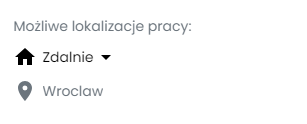

In [ ]:
unique_Locations = get_unique_features(df, 'Locations')
unique_Locations

{'Baranyai',
 'Borsod-Abaúj-Zempléń',
 'Bácskai-Kiskun',
 'Békési',
 'Csongrádi',
 'Dolnośląskie',
 'Fejér',
 'Győr-Moson-Sopron',
 'Hajdú-Bihar',
 'Heves',
 'Jász-Nagykun-Szolnoki',
 'Komárom-Esztergomi',
 'Kujawsko-Pomorskie',
 'Lubelskie',
 'Lubuskie',
 'Mazowieckie',
 'Małopolskie',
 'Nógrád',
 'Opolskie',
 'Pester',
 'Podkarpackie',
 'Podlaskie',
 'Pomorskie',
 'Somogyi',
 'Szabolcs-Szatmár-Beregi',
 'Tolnai',
 'Vas',
 'Veszprémi',
 'Warmińsko-Mazurskie',
 'Wielkopolskie',
 'Zachodniopomorskie',
 'Zala',
 'Zdalnie',
 'Łódzkie',
 'Śląskie',
 'Świętokrzyskie'}

In [ ]:
df['Locationsclr'] = df['Locations'].apply(lambda x: [value.split(' , ')[0].strip() for value in x])
df['Locationsclr'] = df['Locationsclr'].apply(lambda x: [value.split(',')[0].strip() for value in x]) #w przypadku gdy przecinek występował zaraz po nazwie miejscowości np.: Warszawa, ul.Krakowska - mieliśmy podany dokładny adres miejsca pracy, nie jest nam potrzebna taka informacja więc bierzemy wszystko co jest na lewo od przecinka
df['Locationsclr'] = df['Locationsclr'].apply(lambda x: [unidecode(value) for value in x]) #usunięcie polskich znaków
df['Locationsclr'] = df['Locationsclr'].apply(lambda locations: list(set(locations))) #usunięcie duplikatów w obrębie każdej komórki

df['Locations2clr'] = df['Locations2'].apply(lambda x: [value.split(' , ')[0].strip() for value in x])
df['Locations2clr'] = df['Locations2clr'].apply(lambda x: [value.split(',')[0].strip() for value in x])
df['Locations2clr'] = df['Locations2clr'].apply(lambda x: [unidecode(value) for value in x])
df['Locations2clr'] = df['Locations2clr'].apply(lambda x: [value.replace('Warsaw', 'Warszawa') for value in x]) #Warszawa występowała w dwóch językach, ujednolicam nazewnictwo

df['Locations2clr'] = df['Locations2clr'].apply(lambda locations: list(set(locations)))

df.head(2)

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,...,Offer Age,Job Name Mapped,Required Skills Mapped,Seniority Level Num,Benefits Mapped,Hardware Mapped,Has Mac,Has Monitors,Locationsclr,Locations2clr
0,Praca Business SQL Developer | Data | Harvey N...,Business SQL Developer,Harvey Nash Technology,"[Utworzona w: 1988, Wielkość firmy: 8000+, S...","Mid,Senior","[SQL, SQL Server, Python, Alteryx, Data wareho...",25 000 – 32 000 PLN,[],"[Hybrydowo, Warszawa]","[Rekrutacja online, Język rekrutacji: polski&a...",...,Oferta opublikowana dzisiaj,Data Engineer,"[Others, Databases, SQL, Data Governance, Python]",3,"[International, Training & Conferences, Fitnes...",[],NaN,NaN,[],"[Warszawa, Hybrydowo]"
1,Praca Cloud Data Architect (GCP/Azure) | Data ...,Cloud Data Architect (GCP/Azure),Elitmind,"[Utworzona w: 2015, Wielkość firmy: +100, Lo...","Senior,Expert","[google cloud platform, ETL, SQL, Azure Cloud,...",24 000 – 32 000 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...",...,Oferta opublikowana dzisiaj,Data Engineer,"[Data Integration, Others, SQL, Cloud, Data Go...",5,"[Training & Conferences, International, Organi...","[Notebook/PC, Two Monitors]",False,True,"[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie,...","[Lodzkie, Krakow, Wielkopolskie, Pomorskie, Lu..."


In [ ]:
cleared_locations = get_unique_features(df, 'Locationsclr')
textwrap.wrap(str(cleared_locations), width=300)

["{'Lodzkie', 'Hajdu-Bihar', 'Warminsko-Mazurskie', 'Csongradi', 'Szabolcs-Szatmar-Beregi', 'Vas', 'Bacskai-Kiskun', 'Podkarpackie', 'Wielkopolskie', 'Pomorskie', 'Lubelskie', 'Somogyi', 'Nograd', 'Zdalnie', 'Gyor-Moson-Sopron', 'Komarom-Esztergomi', 'Bekesi', 'Zala', 'Jasz-Nagykun-Szolnoki',",
 "'Mazowieckie', 'Lubuskie', 'Veszpremi', 'Zachodniopomorskie', 'Kujawsko-Pomorskie', 'Dolnoslaskie', 'Tolnai', 'Fejer', 'Swietokrzyskie', 'Baranyai', 'Opolskie', 'Slaskie', 'Heves', 'Podlaskie', 'Borsod-Abauj-Zemplen', 'Pester', 'Malopolskie'}"]

In [ ]:
cleared_locations2 = get_unique_features(df, 'Locations2clr')
textwrap.wrap(str(cleared_locations2), width=300)

["{'Lodzkie', 'Gliwice', 'Hajdu-Bihar', 'Warminsko-Mazurskie', 'Sopot', 'Csongradi', 'Szabolcs-Szatmar-Beregi', 'Vas', '5/1', 'Lodz', 'Bacskai-Kiskun', 'Podkarpackie', 'Krakow', 'Wielkopolskie', 'Pomorskie', 'Lubelskie', 'Somogyi', 'Pila', 'Nograd', 'Zdalnie', 'Gyor-Moson-Sopron', 'Rzeszow',",
 "'Warszawa', 'Komarom-Esztergomi', 'Bekesi', 'Zala', 'Jasz-Nagykun-Szolnoki', 'Szolnok', 'Mazowieckie', 'Bialystok', 'Lubuskie', 'Poznan', 'Veszpremi', 'Gdansk', 'Wroclaw', 'Torun', 'Zachodniopomorskie', 'Kujawsko-Pomorskie', 'Dolnoslaskie', '411', 'Gdynia', 'Tolnai', 'Lublin', 'Hybrydowo',",
 "'Szczecin', 'Kielce', 'Fejer', 'Bydgoszcz', 'Swietokrzyskie', 'Katowice', 'Baranyai', 'Opolskie', 'Slaskie', 'San Diego', 'Heves', 'Czestochowa', 'Paznan', 'Budapest', 'Podlaskie', 'Borsod-Abauj-Zemplen', 'Pester', 'Malopolskie'}"]

Tworzę kolumnę ze wszystkimi lokalizacjami z obu powyższych kolumn

In [ ]:
df['All Locations'] = df['Locationsclr'] + df['Locations2clr']
df['All Locations'] = df['All Locations'].apply(lambda locations: list(set(locations)))

all_locations = get_unique_features(df, 'All Locations')
textwrap.wrap(str(all_locations), width=300)

["{'Lodzkie', 'Gliwice', 'Hajdu-Bihar', 'Warminsko-Mazurskie', 'Sopot', 'Csongradi', 'Szabolcs-Szatmar-Beregi', 'Vas', '5/1', 'Lodz', 'Bacskai-Kiskun', 'Podkarpackie', 'Krakow', 'Wielkopolskie', 'Pomorskie', 'Lubelskie', 'Somogyi', 'Pila', 'Nograd', 'Zdalnie', 'Gyor-Moson-Sopron', 'Rzeszow',",
 "'Warszawa', 'Komarom-Esztergomi', 'Bekesi', 'Zala', 'Jasz-Nagykun-Szolnoki', 'Szolnok', 'Mazowieckie', 'Bialystok', 'Lubuskie', 'Poznan', 'Veszpremi', 'Gdansk', 'Wroclaw', 'Torun', 'Zachodniopomorskie', 'Kujawsko-Pomorskie', 'Dolnoslaskie', '411', 'Gdynia', 'Tolnai', 'Lublin', 'Hybrydowo',",
 "'Szczecin', 'Kielce', 'Fejer', 'Bydgoszcz', 'Swietokrzyskie', 'Katowice', 'Baranyai', 'Opolskie', 'Slaskie', 'San Diego', 'Heves', 'Czestochowa', 'Paznan', 'Budapest', 'Podlaskie', 'Borsod-Abauj-Zemplen', 'Pester', 'Malopolskie'}"]

W kolumnie *All Locations* szukam takich wartości które nie mają uzupełnionej kolumny *Locationsclr* która odpowiada województwu.

In [ ]:
cities = [list(set(row['All Locations'])) for idx, row in df.iterrows() if row['Locationsclr'] == []]
cities = list(set([item for sublist in cities for item in sublist]))
cities

['Kielce',
 'Krakow',
 'Gliwice',
 'Bydgoszcz',
 'Sopot',
 'Katowice',
 'Poznan',
 'Gdansk',
 'San Diego',
 'Wroclaw',
 'Lodz',
 'Budapest',
 'Warszawa',
 'Gdynia',
 'Szolnok',
 'Lublin',
 'Hybrydowo']

Mapuję brakujące województwa i wydzielam kolumnę *Voivodeship*

In [ ]:
voivodeship_dict = {
    'Gdynia': 'Pomorskie',
    'Budapest': 'Foreign',
    'San Diego': 'Foreign',
    'Szolnok': 'Foreign',
    'Gliwice': 'Slaskie',
    'Katowice': 'Slaskie',
    'Lodz': 'Lodzkie',
    'Wroclaw': 'Dolnoslaskie',
    'Krakow': 'Malopolskie',
    'Poznan': 'Wielkopolskie',
    'Sopot': 'Pomorskie',
    'Kielce': 'Swietokrzyskie',
    'Bydgoszcz': 'Kujawsko-Pomorskie',
    'Lublin': 'Lubelskie',
    'Warszawa': 'Mazowieckie',
    'Gdansk': 'Pomorskie',
    'Zdalnie': None,
    'Hybrydowo': None
}


##zauważam że kolumna Locationsclr to głównie Województwa
df['Voivodeship'] = df['Locationsclr'].map(lambda x: [value for value in x if value != 'Zdalnie' and value != 'Hybrydowo'])

for idx, row in df.iterrows():
    if row['Voivodeship'] == []:
       df.at[idx, 'Voivodeship'] = [voivodeship_dict.get(location, 'Foreign') for location in row['All Locations']]

df['Voivodeship'] = df['Voivodeship'].map(lambda x: [value for value in x if value is not None])

df.head(5)

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,...,Required Skills Mapped,Seniority Level Num,Benefits Mapped,Hardware Mapped,Has Mac,Has Monitors,Locationsclr,Locations2clr,All Locations,Voivodeship
0,Praca Business SQL Developer | Data | Harvey N...,Business SQL Developer,Harvey Nash Technology,"[Utworzona w: 1988, Wielkość firmy: 8000+, S...","Mid,Senior","[SQL, SQL Server, Python, Alteryx, Data wareho...",25 000 – 32 000 PLN,[],"[Hybrydowo, Warszawa]","[Rekrutacja online, Język rekrutacji: polski&a...",...,"[Others, Databases, SQL, Data Governance, Python]",3,"[International, Training & Conferences, Fitnes...",[],NaN,NaN,[],"[Warszawa, Hybrydowo]","[Warszawa, Hybrydowo]",[Mazowieckie]
1,Praca Cloud Data Architect (GCP/Azure) | Data ...,Cloud Data Architect (GCP/Azure),Elitmind,"[Utworzona w: 2015, Wielkość firmy: +100, Lo...","Senior,Expert","[google cloud platform, ETL, SQL, Azure Cloud,...",24 000 – 32 000 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...",...,"[Data Integration, Others, SQL, Cloud, Data Go...",5,"[Training & Conferences, International, Organi...","[Notebook/PC, Two Monitors]",False,True,"[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie,...","[Lodzkie, Krakow, Wielkopolskie, Pomorskie, Lu...","[Lodzkie, Krakow, Wielkopolskie, Pomorskie, Lu...","[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie,..."
2,Praca Data Engineer | Data | ASTEK Polska | Z...,Data Engineer,ASTEK Polska,"[Utworzona w: 2007, Wielkość firmy: +1000, L...",Senior,"[Python, AWS, SQL]",21 000 – 27 300 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...",...,"[Cloud, SQL, Python]",4,"[International, Fitness, Health]","[Notebook/PC, One Monitor]",False,True,"[Lodzkie, Mazowieckie, Wielkopolskie, Pomorski...","[Lodzkie, Mazowieckie, Wielkopolskie, Pomorski...","[Lodzkie, Mazowieckie, Wielkopolskie, Pomorski...","[Lodzkie, Mazowieckie, Wielkopolskie, Pomorski..."
3,Praca Mid/Senior MLOps Engineer | AI | GetInDa...,Mid/Senior MLOps Engineer,GetInData | Part of Xebia,"[Oferta pracy ze wsparciem dla uchodźców, Utwo...","Mid,Senior","[GCP, Java, Python, Kubernetes, Machine learni...",16 800 – 33 600 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski&a...",...,"[Data Integration, Others, Databases, DevOps, ...",3,"[International, Organization, Health, Events, ...","[Notebook/PC, Mac, Two Monitors]",True,True,"[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie,...","[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie,...","[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie,...","[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie,..."
4,Praca Senior Machine Learning NLP LLM Engineer...,Senior Machine Learning NLP LLM Engineer,Kinetix Trading Solutions,"[Utworzona w: 2010, Wielkość firmy: 40+, Sie...","Senior,Expert","[Python, Machine learning, scikit-learn, NLP, ...",25 000 – 32 000 PLN,"[Zdalnie, Kujawsko-Pomorskie, Łódzkie, Lubelsk...","[Kujawsko-Pomorskie, Łódzkie, Lubelskie, Lubus...","[Rekrutacja online, Język rekrutacji: angielsk...",...,"[NoSQL, Others, Version Control, DevOps, Cloud...",5,"[International, Organization, Technology, Work...",[Notebook/PC],False,False,"[Lodzkie, Lubelskie, Swietokrzyskie, Warminsko...","[Lodzkie, Krakow, Lubelskie, Swietokrzyskie, W...","[Lodzkie, Krakow, Lubelskie, Swietokrzyskie, W...","[Lodzkie, Lubelskie, Swietokrzyskie, Warminsko..."


In [ ]:
unique_Voivodeship = get_unique_features(df, 'Voivodeship')
unique_Voivodeship

{'Bacskai-Kiskun',
 'Baranyai',
 'Bekesi',
 'Borsod-Abauj-Zemplen',
 'Csongradi',
 'Dolnoslaskie',
 'Fejer',
 'Foreign',
 'Gyor-Moson-Sopron',
 'Hajdu-Bihar',
 'Heves',
 'Jasz-Nagykun-Szolnoki',
 'Komarom-Esztergomi',
 'Kujawsko-Pomorskie',
 'Lodzkie',
 'Lubelskie',
 'Lubuskie',
 'Malopolskie',
 'Mazowieckie',
 'Nograd',
 'Opolskie',
 'Pester',
 'Podkarpackie',
 'Podlaskie',
 'Pomorskie',
 'Slaskie',
 'Somogyi',
 'Swietokrzyskie',
 'Szabolcs-Szatmar-Beregi',
 'Tolnai',
 'Vas',
 'Veszpremi',
 'Warminsko-Mazurskie',
 'Wielkopolskie',
 'Zachodniopomorskie',
 'Zala'}

Jak możemy zauważyć, znajdują się tutaj też zagraniczne rejony.

##### Utworzenie dodatkowych flag związanych z lokalizacją pracy

In [ ]:
df['IsRemote'] = df.apply(lambda row: any('Zdalnie' in loc for loc in row['All Locations']), axis=1)
df['IsHybrid'] = df.apply(lambda row: any('Hybrydowo' in loc for loc in row['All Locations']), axis=1)
display(df.head(2))

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,...,Benefits Mapped,Hardware Mapped,Has Mac,Has Monitors,Locationsclr,Locations2clr,All Locations,Voivodeship,IsRemote,IsHybrid
0,Praca Business SQL Developer | Data | Harvey N...,Business SQL Developer,Harvey Nash Technology,"[Utworzona w: 1988, Wielkość firmy: 8000+, S...","Mid,Senior","[SQL, SQL Server, Python, Alteryx, Data wareho...",25 000 – 32 000 PLN,[],"[Hybrydowo, Warszawa]","[Rekrutacja online, Język rekrutacji: polski&a...",...,"[International, Training & Conferences, Fitnes...",[],NaN,NaN,[],"[Warszawa, Hybrydowo]","[Warszawa, Hybrydowo]",[Mazowieckie],False,True
1,Praca Cloud Data Architect (GCP/Azure) | Data ...,Cloud Data Architect (GCP/Azure),Elitmind,"[Utworzona w: 2015, Wielkość firmy: +100, Lo...","Senior,Expert","[google cloud platform, ETL, SQL, Azure Cloud,...",24 000 – 32 000 PLN,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...",...,"[Training & Conferences, International, Organi...","[Notebook/PC, Two Monitors]",False,True,"[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie,...","[Lodzkie, Krakow, Wielkopolskie, Pomorskie, Lu...","[Lodzkie, Krakow, Wielkopolskie, Pomorskie, Lu...","[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie,...",True,False


#### Informacje o wynagrodzeniu

In [ ]:
df['Salary'] = df['Salary'].str.replace(' PLN', '')  #Usuwam 'PLN' z kolumny

df[['Min Salary', 'Max Salary']] = df['Salary'].str.split(' – ', expand=True)  #Rozdzielam wynagrodzenie na MIN i MAX

df['Min Salary'] = df['Min Salary'].str.replace('\xa0', '').astype(float)  #Usuwam białe znaki
df['Max Salary'] = df['Max Salary'].str.replace('\xa0', '').astype(float)

display(df.head(2))

,Title,Job Name,Company Name,Company Details,Seniority Level,Required Skills,Salary,Locations,Locations2,Details,...,Has Mac,Has Monitors,Locationsclr,Locations2clr,All Locations,Voivodeship,IsRemote,IsHybrid,Min Salary,Max Salary
0,Praca Business SQL Developer | Data | Harvey N...,Business SQL Developer,Harvey Nash Technology,"[Utworzona w: 1988, Wielkość firmy: 8000+, S...","Mid,Senior","[SQL, SQL Server, Python, Alteryx, Data wareho...",25 000 – 32 000,[],"[Hybrydowo, Warszawa]","[Rekrutacja online, Język rekrutacji: polski&a...",...,NaN,NaN,[],"[Warszawa, Hybrydowo]","[Warszawa, Hybrydowo]",[Mazowieckie],False,True,25000.0,32000.0
1,Praca Cloud Data Architect (GCP/Azure) | Data ...,Cloud Data Architect (GCP/Azure),Elitmind,"[Utworzona w: 2015, Wielkość firmy: +100, Lo...","Senior,Expert","[google cloud platform, ETL, SQL, Azure Cloud,...",24 000 – 32 000,"[Zdalnie, Dolnośląskie, Kujawsko-Pomorskie, Łó...","[Dolnośląskie, Kujawsko-Pomorskie, Łódzkie, Lu...","[Rekrutacja online, Język rekrutacji: polski, ...",...,False,True,"[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie,...","[Lodzkie, Krakow, Wielkopolskie, Pomorskie, Lu...","[Lodzkie, Krakow, Wielkopolskie, Pomorskie, Lu...","[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie,...",True,False,24000.0,32000.0


#### Informacje o firmie

In [ ]:
df['Company Size'] = df['Company Details'].apply(lambda x: [item.split(': ')[1].replace('+', '') for item in x if 'Wielkość firmy' in item]).str[0]
df['Company Size'] = pd.to_numeric(df['Company Size'], errors='coerce')
df['Company Size'].head(5)

0    8000.0
1     100.0
2    1000.0
3     100.0
4      40.0
Name: Company Size, dtype: float64

In [ ]:
df['Est Year'] = df['Company Details'].apply(lambda x: [item.split(': ')[1] for item in x if 'Utworzona w' in item]).str[0]
df['Est Year'] = pd.to_numeric(df['Est Year'], errors='coerce')
df['Est Year'].head(5)

0    1988.0
1    2015.0
2    2007.0
3    2014.0
4    2010.0
Name: Est Year, dtype: float64

In [ ]:
df['Headquaters'] = df['Company Details'].apply(lambda x: [item.split(': ')[1] for item in x if 'Siedziba' in item]).str[0]
df['Headquaters'] = df['Headquaters'].astype(str)
df['Headquaters'] = df['Headquaters'].str.replace('Warsaw', 'Warszawa')
df['Headquaters'].head(5)

0      Warszawa
1           nan
2           nan
3      Warszawa
4     Princeton
Name: Headquaters, dtype: object

### Umieszczenie przygotowanych danych w nowej ramce

In [ ]:
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_rows', None)

new_df = df[['Job Name', 'Job Name Mapped', 'Company Name', 'Company Size', 'Est Year', 'Seniority Level', 'Seniority Level Num', 'Min Salary', 'Max Salary', 'Required Skills', 'Required Skills Mapped', 'Facilities', 'Benefits', 'Benefits Mapped', 'All Locations', 'Voivodeship', 'Hardware', 'Hardware Mapped', 'Has Mac', 'IsRemote', 'IsHybrid']]
new_df.head(2)

,Job Name,Job Name Mapped,Company Name,Company Size,Est Year,Seniority Level,Seniority Level Num,Min Salary,Max Salary,Required Skills,Required Skills Mapped,Facilities,Benefits,Benefits Mapped,All Locations,Voivodeship,Hardware,Hardware Mapped,Has Mac,IsRemote,IsHybrid
0,Business SQL Developer,Data Engineer,Harvey Nash Technology,8000.00,1988.00,"Mid,Senior",3,25000.00,32000.00,"[SQL, SQL Server, Python, Alteryx, Data warehouse, Data Lake, Databricks]","[Others, Databases, SQL, Data Governance, Python]","[Free coffee, Bike parking, Playroom, Free beverages, Free snacks, Startup atmosphere, Modern office, No dress code]","[Sport subscription, Training budget, Private healthcare, International projects]","[International, Training & Conferences, Fitness, Health]","[Warszawa, Hybrydowo]",[Mazowieckie],[],[],NaN,False,True
1,Cloud Data Architect (GCP/Azure),Data Engineer,Elitmind,100.00,2015.00,"Senior,Expert",5,24000.00,32000.00,"[google cloud platform, ETL, SQL, Azure Cloud, Data Governance, ETL/ELT, Data Architecture, Data Platforms, Stakeholder Management, Cloud Migratio...","[Data Integration, Others, SQL, Cloud, Data Governance]","[Free coffee, Bike parking, Modern office, Office in the city center]","[Sport subscription, Training budget, Private healthcare, Flat structure, Small teams, International projects, Employee programs, English lessons,...","[Training & Conferences, International, Organization, Health, Programs, Work Environment, Language, Events, Fitness]","[Lodzkie, Krakow, Wielkopolskie, Pomorskie, Lubelskie, Swietokrzyskie, Warminsko-Mazurskie, Lubuskie, Opolskie, Slaskie, Zdalnie, Zachodniopomorsk...","[Lodzkie, Wielkopolskie, Pomorskie, Lubelskie, Swietokrzyskie, Warminsko-Mazurskie, Lubuskie, Opolskie, Slaskie, Podlaskie, Zachodniopomorskie, Ku...","[Windows, Komputer: Notebook, Monitory: Dwa]","[Notebook/PC, Two Monitors]",False,True,False


In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Job Name                157 non-null    object 
 1   Job Name Mapped         157 non-null    object 
 2   Company Name            157 non-null    object 
 3   Company Size            106 non-null    float64
 4   Est Year                111 non-null    float64
 5   Seniority Level         157 non-null    object 
 6   Seniority Level Num     157 non-null    int64  
 7   Min Salary              157 non-null    float64
 8   Max Salary              155 non-null    float64
 9   Required Skills         157 non-null    object 
 10  Required Skills Mapped  157 non-null    object 
 11  Facilities              157 non-null    object 
 12  Benefits                157 non-null    object 
 13  Benefits Mapped         157 non-null    object 
 14  All Locations           157 non-null    ob

Jak zauważyliśmy na samym początku - konieczne jest poprawienie wyświetlania wartości pustych dla list umieszczonych w komórkach ramki danych.

In [ ]:
for column in new_df.columns:
    for index, value in enumerate(new_df[column]):
        if isinstance(value, list) and value == []:
            new_df.at[index, column] = None
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Job Name                157 non-null    object 
 1   Job Name Mapped         157 non-null    object 
 2   Company Name            157 non-null    object 
 3   Company Size            106 non-null    float64
 4   Est Year                111 non-null    float64
 5   Seniority Level         157 non-null    object 
 6   Seniority Level Num     157 non-null    int64  
 7   Min Salary              157 non-null    float64
 8   Max Salary              155 non-null    float64
 9   Required Skills         157 non-null    object 
 10  Required Skills Mapped  157 non-null    object 
 11  Facilities              122 non-null    object 
 12  Benefits                142 non-null    object 
 13  Benefits Mapped         142 non-null    object 
 14  All Locations           157 non-null    ob

## Analiza danych i wizualizacja dancych

### Liczby poszczególnych ofert w zależności od wymaganego doświadczenia

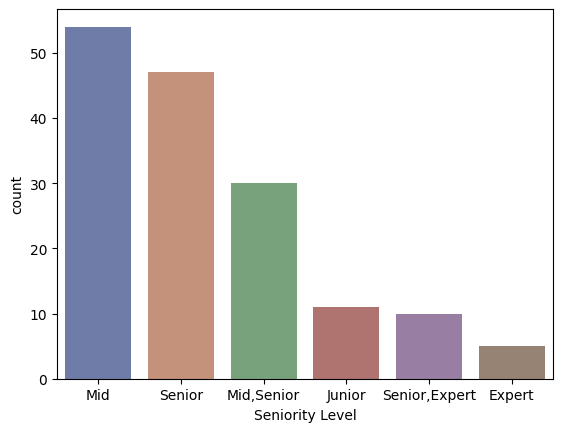

In [ ]:
g = sns.countplot(data=new_df, x='Seniority Level', palette='dark', alpha=.6, order=new_df['Seniority Level'].value_counts().index)

### Liczby ofert w zależności od nazwy stanowiska

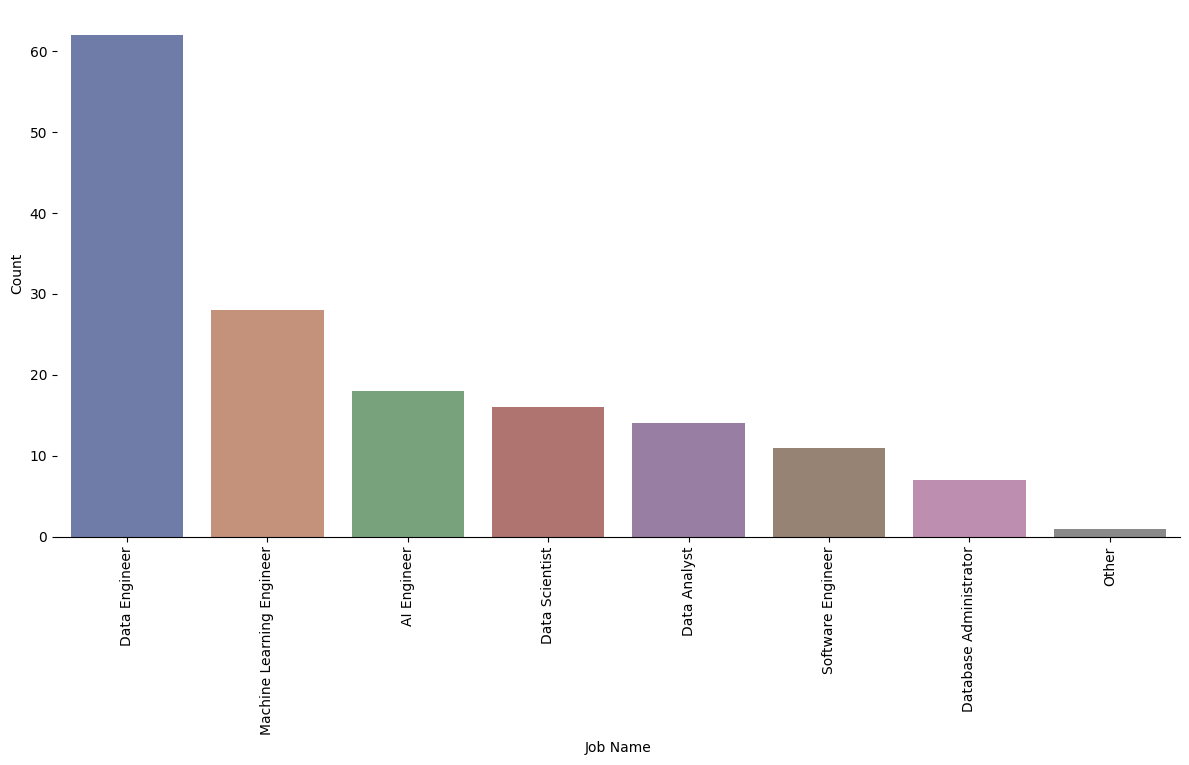

In [ ]:
g = sns.catplot(data=new_df, kind='count',
                x='Job Name Mapped', 
                ci='sd', palette='dark', alpha=.6, height=6,aspect=2, order=new_df['Job Name Mapped'].value_counts().index)
g = g.despine(left=True)
g = g.set_axis_labels('Job Name', 'Count')
g = g.set_xticklabels(rotation=90)

### Wynagrodzenie w zależności od doświadczenia

<ipython-input-138-311aaf2cd0b4>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(data=new_df, kind='bar',


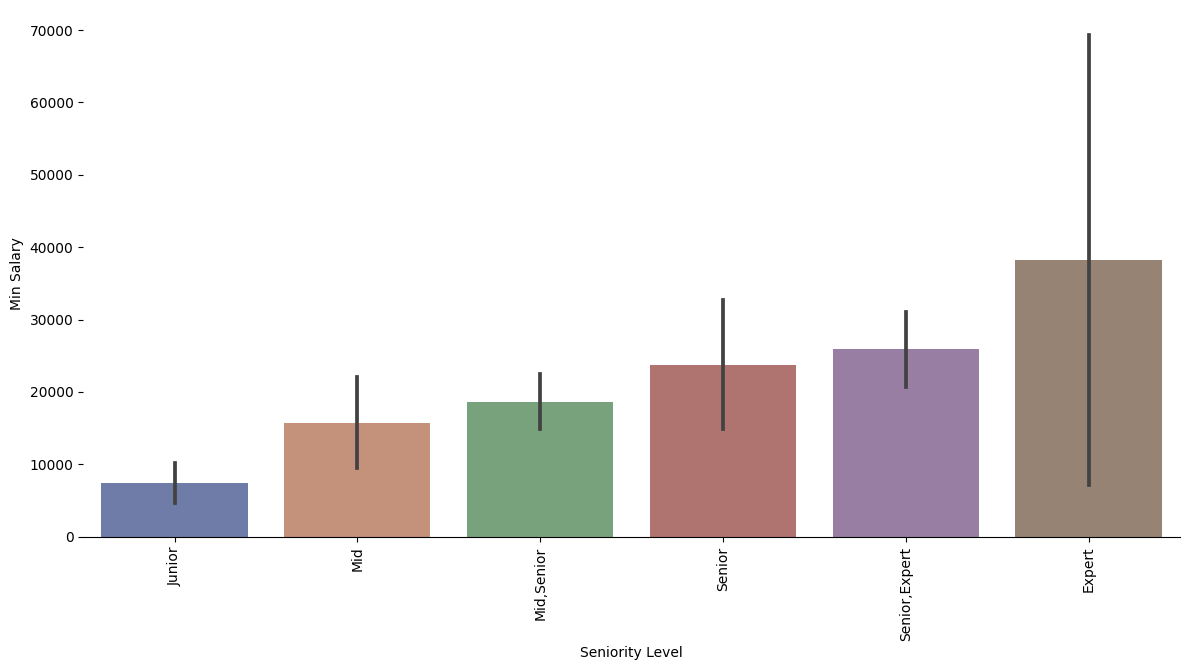

In [ ]:
g = sns.catplot(data=new_df, kind='bar',
                x='Seniority Level', y='Min Salary', 
                ci='sd', palette='dark', alpha=.6, height=6,aspect=2, order= ['Junior','Mid','Mid,Senior','Senior','Senior,Expert','Expert'])
g = g.despine(left=True)
g = g.set_axis_labels('Seniority Level', "Min Salary")
g = g.set_xticklabels(rotation=90)

### Wynagrodzenie w zależności od stanowiska

<ipython-input-61-373aac52cde2>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(data=new_df, kind='bar',


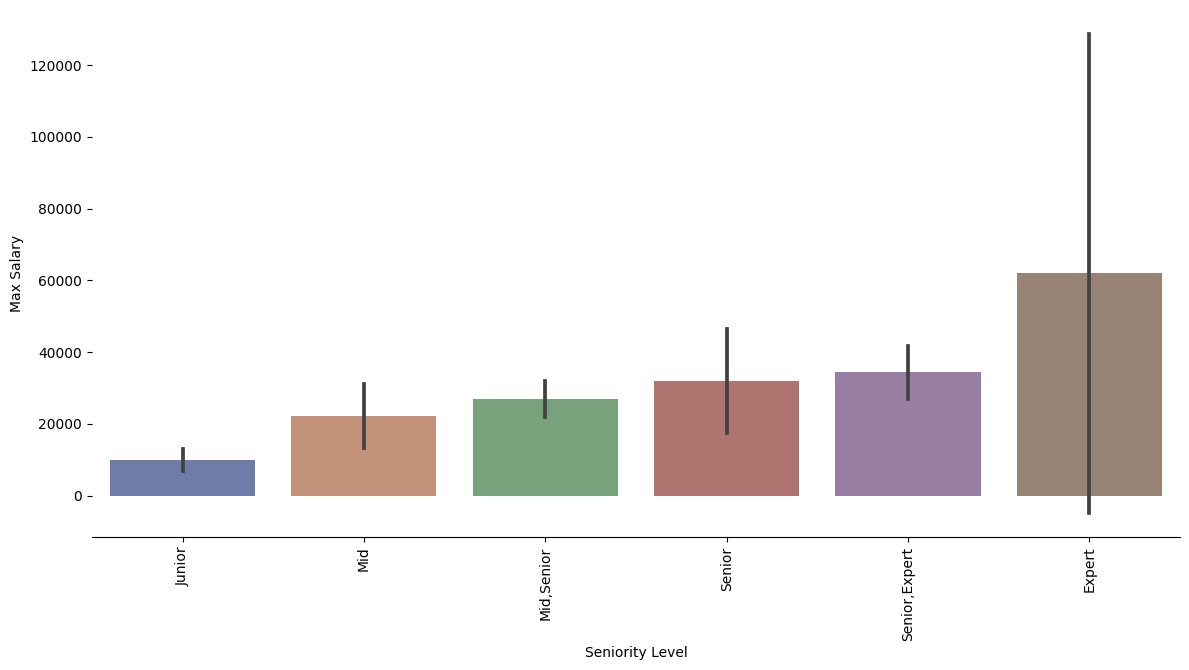

In [ ]:
g = sns.catplot(data=new_df, kind='bar',
                x='Seniority Level', y='Max Salary', 
                ci='sd', palette='dark', alpha=.6, height=6,aspect=2, order= ['Junior','Mid','Mid,Senior','Senior','Senior,Expert','Expert'])
g = g.despine(left=True)
g = g.set_axis_labels('Seniority Level', "Max Salary")
g = g.set_xticklabels(rotation=90)

<ipython-input-139-24c103fbf1ca>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Avg Salary'] = (new_df['Max Salary'] + new_df['Min Salary']) / 2


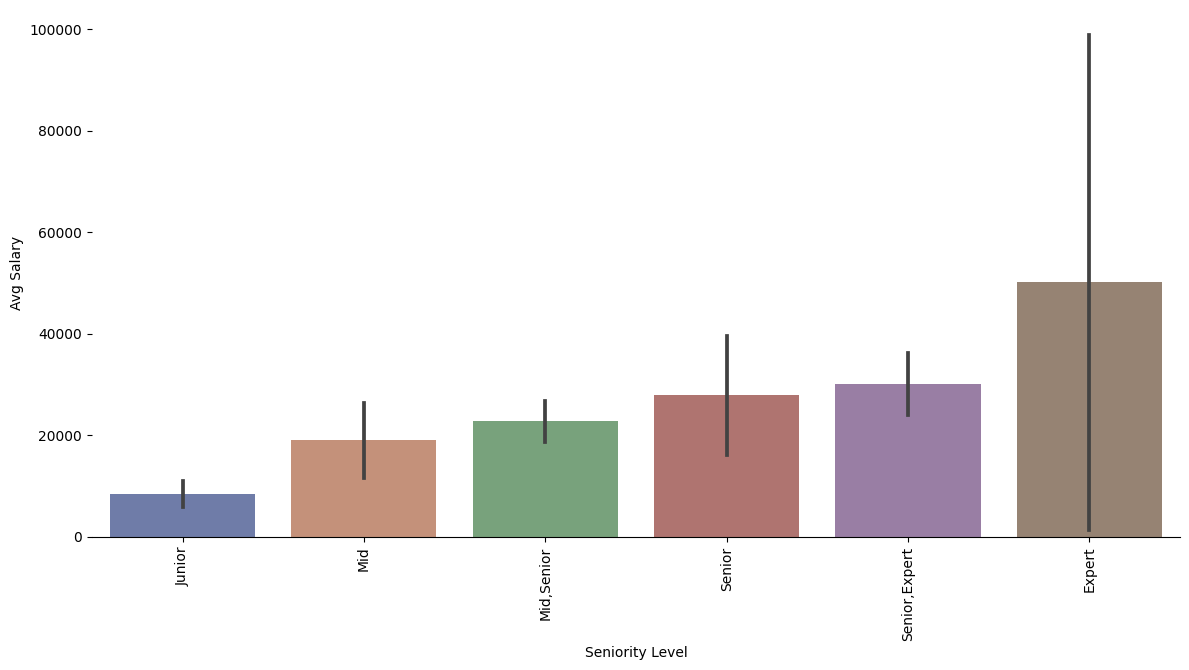

In [ ]:
new_df['Avg Salary'] = (new_df['Max Salary'] + new_df['Min Salary']) / 2

g = sns.catplot(data=new_df, kind='bar',
                x='Seniority Level', y='Avg Salary', 
                errorbar='sd', palette='dark', alpha=.6, height=6,aspect=2, order= ['Junior','Mid','Mid,Senior','Senior','Senior,Expert','Expert'])
g = g.despine(left=True)
g = g.set_axis_labels('Seniority Level', 'Avg Salary')
g = g.set_xticklabels(rotation=90)

### Wynagrodzenie w zależności od stanowiska i doświadczenia

<ipython-input-141-b8da4f3f7a09>:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(data=new_df, kind='bar',


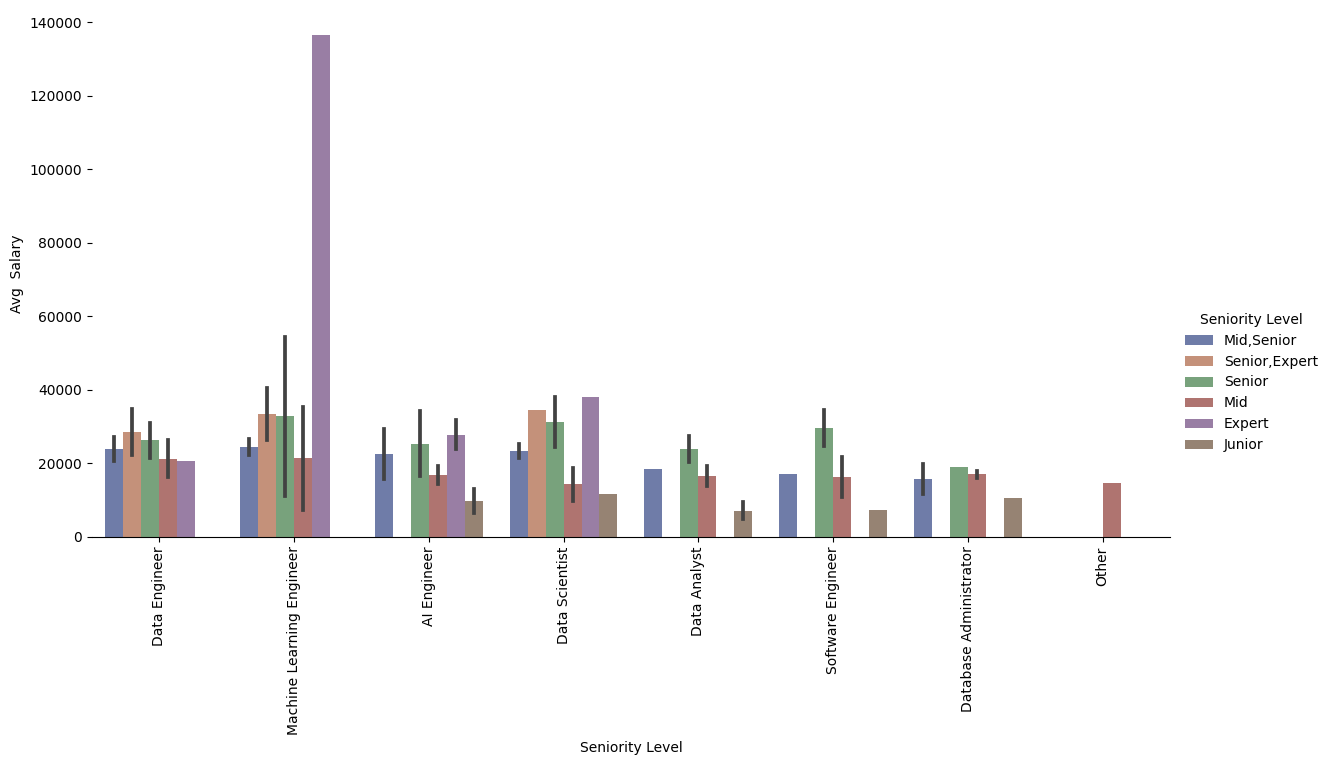

In [ ]:
g = sns.catplot(data=new_df, kind='bar',
                x='Job Name Mapped', y='Avg Salary', hue='Seniority Level', 
                ci='sd', palette='dark', alpha=.6, height=6,aspect=2, order=new_df['Job Name Mapped'].value_counts().index)

g = g.despine(left=True)
g = g.set_axis_labels('Seniority Level', 'Avg  Salary')
g = g.set_xticklabels(rotation=90)

### Najczęściej wymagane umiejętności

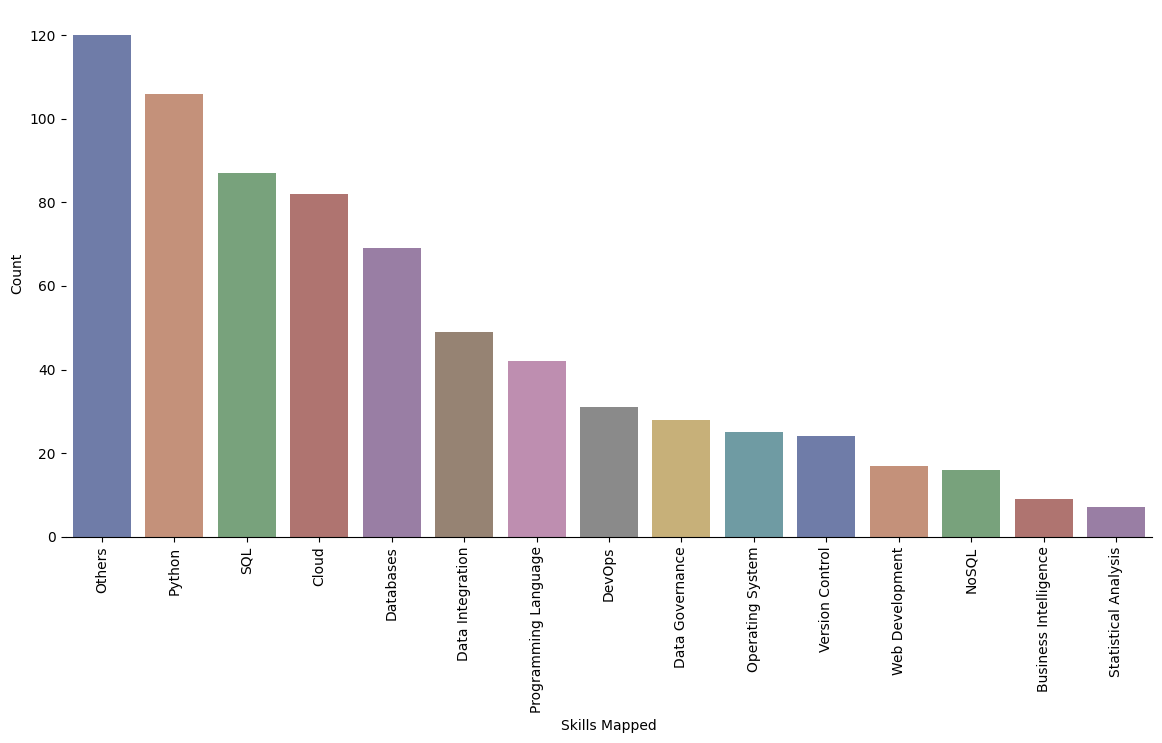

In [ ]:
flatten_skills = pd.DataFrame(new_df['Required Skills Mapped'].explode().dropna())

g = sns.catplot(data=flatten_skills, kind='count',
                x='Required Skills Mapped', 
                ci='sd', palette='dark', alpha=.6, height=6,aspect=2, order=flatten_skills['Required Skills Mapped'].value_counts().index)
g = g.despine(left=True)
g = g.set_axis_labels('Skills Mapped', 'Count')
g = g.set_xticklabels(rotation=90)

### Najczęściej występujące benefity

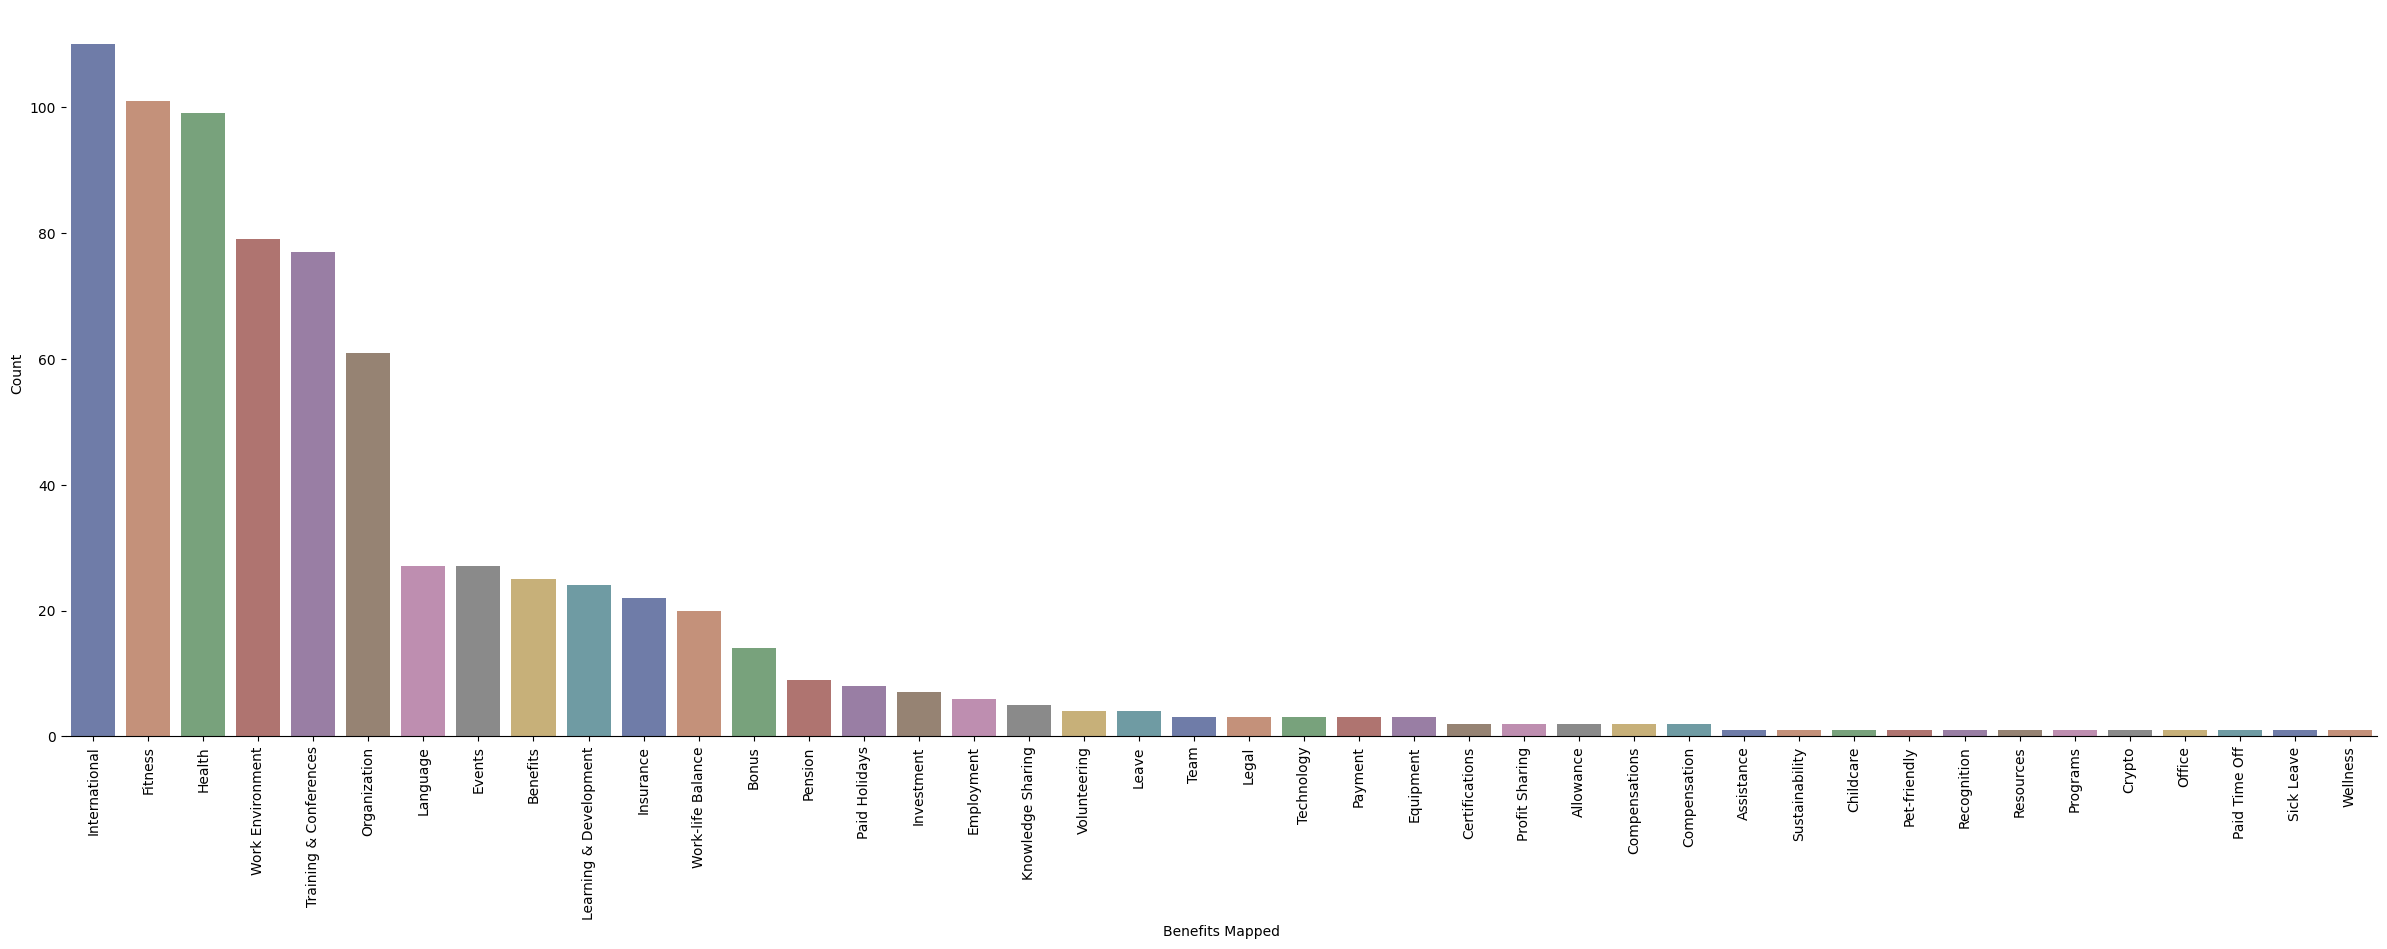

In [ ]:
flatten_benefits = pd.DataFrame(new_df['Benefits Mapped'].explode().dropna())

g = sns.catplot(data=flatten_benefits, kind='count',
                x='Benefits Mapped', 
                ci='sd', palette='dark', alpha=.6, height=8,aspect=3, order=flatten_benefits['Benefits Mapped'].value_counts().index)
g = g.despine(left=True)
g = g.set_axis_labels('Benefits Mapped', 'Count')
g = g.set_xticklabels(rotation=90)

### Praca zdalna/hybrydowa

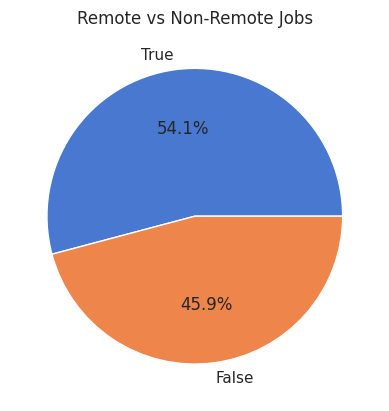

In [ ]:
remote_counts = new_df['IsRemote'].value_counts()
sns.set_palette('muted') 
g = plt.pie(remote_counts, labels = remote_counts.index, autopct='%1.1f%%')
g = plt.title('Remote vs Non-Remote Jobs')

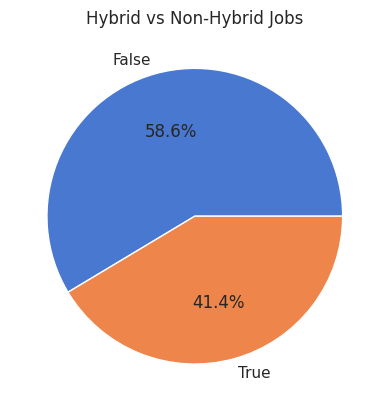

In [ ]:
hybrid_counts = new_df['IsHybrid'].value_counts()
sns.set_palette('muted') 
g = plt.pie(hybrid_counts, labels = hybrid_counts.index, autopct='%1.1f%%')
g = plt.title('Hybrid vs Non-Hybrid Jobs')

# Dyskusja otrzymanych wyników

### Wnioski

W procesie pozyskiwania danych metodą Webscraping'u kluczowe znaczenie ma odpowiednia obróbka pobranych danych. Wymaga to analizy tego co znajduje się w każdej z kolumn, a następnie obrania odpowiedniej strategii "co z tymi danymi zrobić". 

Jest to proces bardzo czasochłonny, w szczególności gdy konieczne jest odpowiednie pogrupowanie różnych zbiorów cech. Zbyt duże rozdrobnienie lub powielenie tych samych informacji pod podobną nazwą spowodowałoby, że wnioski wyciągane w dalszej analizie niekoniecznie byłyby poprawne.

### Plany na przyszłość

Algorytm po odpowiednim rozbudowaniu mógłby służyć do ciągłego pozyskiwania danych o ofertach pracy z tego serwisu. Moglibyśmy w ten sposób utworzyć ogromny zbiór odpowiednio zmapowanych ofert pracy, które miałyby zastosowanie w dalszej analizie, śledzeniu trendów. Dodatkowo warte rozważenia byłyby znaczniki czasowe dzięki którym możliwe byłoby szacowanie czasu przez jaki dane ogłoszenie było aktywne.

Taki proces wiązałby się jednak z ciągłym monitorowaniem poprawności mapowania wszystkich kolumn, być może lepszym rozwiązaniem byłoby przebudowanie kodu tak aby wszystkie mapowane kolumny wykorzystywały tylko słowa kluczowe. Niestety serwis NoFluffJobs oprócz sugerowanych wartości prawdopodobnie pozwala na ręczne wprowadzanie tekstu przez co widać w każdej z kolumn pewne odstępstwa od reguł.

# Bibliografia

* https://nofluffjobs.com/pl
* https://www.youtube.com/watch?v=e9oOj5jRHrM
* https://www.youtube.com/watch?v=XVv6mJpFOb0
* https://www.crummy.com/software/BeautifulSoup/bs4/doc/
* https://docs.python.org/3/library/re.html
* https://seaborn.pydata.org/index.html